In [1]:
import pandas as pd
# import tsfresh
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
df = pd.read_csv('../files/graded_data.csv')


In [3]:
target = pd.read_csv('../files/last_attempt.csv')

In [4]:
target['id'] = target['Slide ID']+'_'+target['Well'].astype(str)

In [5]:
!pip install openpyxl

In [6]:
zoe = pd.read_excel('../files/latest_Zoe central.xlsx')

In [16]:
columns_of_interest = [
'Well',
'Slide ID',
'Grade at approx. 65h - Zoe',
'Grade at approx. 65h - Chrysa',
'HCG Test',
'Gestational Sacs',
'Fetal Heart Beat',
'pgs',
'Morphological Grade - Value',
    'tPNf', 't2', 't3', 't4', 't5', 't6', 't7'
    
]

In [17]:
time_cols = ['tPNf', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 'tM']

In [18]:
time_cols_all = ['Start Time',
 'End Time',
 'tPB2',
 'tPNa',
 'tPNf',
 't2',
 't3',
 't4',
 't5',
 't6',
 't7',
 't8',
 't9',
 'tSC',
 'tM',
 'tSB',
 'tB',
 'tEB',
 'tHB',
 'tDead',
 'Dynamic Score - Time',
 'Morphological Grade - Time',
 'transfer',
 'Z Score - Time',
 'Fragmentation - Time 1',

 'Multi Nucleation - Time 1',

 'Blastomere Size - Time 1',


 # 'Irregular Division - Time 1',

 'Comment - Time 1',
 
 'Pronuclei - Time 1',
 ]

In [19]:
with_fetal_heart = zoe.loc[(zoe['Fetal Heart Beat'].notnull())&(zoe['Fetal Heart Beat']!='Unknown')&(zoe['Fetal Heart Beat']!='unknown')]

In [20]:
failed = with_fetal_heart.loc[with_fetal_heart['Fetal Heart Beat']==0]

In [21]:
succeesfull = with_fetal_heart.drop(failed.index).loc[(with_fetal_heart['Fetal Heart Beat'].astype(float)>0.75)]

In [22]:
failed['id'] = failed['Slide ID']+'_'+failed['Well'].astype(str)

C:\Users\hp\AppData\Local\Temp\ipykernel_27400\3599493305.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failed['id'] = failed['Slide ID']+'_'+failed['Well'].astype(str)


In [23]:
succeesfull['id'] = succeesfull['Slide ID']+'_'+with_fetal_heart['Well'].astype(str)

In [24]:
import glob
all_extracted = pd.concat([pd.read_csv(f) for f in glob.glob('all_extracted/*')])

In [25]:
all_extracted['id'] = all_extracted['embryo_id']

In [26]:
succesfull_feats = pd.merge(all_extracted, succeesfull[['id','Fetal Heart Beat']], left_on='embryo_id', right_on='id')

In [27]:
failed_feats = pd.merge(all_extracted, failed[['id','Fetal Heart Beat']], left_on='embryo_id', right_on='id')

In [28]:
full_target = pd.concat([succesfull_feats, failed_feats])

In [29]:
full_target['id'] = full_target['embryo_id']

In [30]:
(full_target['id_x'] == full_target['id_y']).sum()

406936

In [31]:
all_extracted['id'].nunique()

8989

In [ ]:
full_target['Fetal Heart Beat'].value_counts()

Fetal Heart Beat
0    258663
1    111266
2     35219
3      1788
Name: count, dtype: int64

In [ ]:
target_length = 500

In [24]:
features = [
    # 'area', 'eccentricity', 'equivalent_diameter',
    #    'inertia_tensor-0-0', 'inertia_tensor-0-1', 'inertia_tensor-1-0',
    #    'inertia_tensor-1-1', 'major_axis_length', 'minor_axis_length',
       # 'moments_normalized-0-0', 'moments_normalized-0-1',
       # 'moments_normalized-0-2', 'moments_normalized-0-3',
       # 'moments_normalized-1-0', 'moments_normalized-1-1',
       # 'moments_normalized-1-2', 'moments_normalized-1-3',
      'area', 'eccentricity',
       'equivalent_diameter', 'inertia_tensor-0-0', 'inertia_tensor-0-1',
       'inertia_tensor-1-0', 'inertia_tensor-1-1', 'major_axis_length',
       'minor_axis_length', 'perimeter', 'solidity', 'area_diff',
       'eccentricity_diff', 'minor_axis_length_diff', 'major_axis_length_diff',
       'solidity_diff',
    #    'moments_normalized-3-0', 'moments_normalized-3-1',
    #    'moments_normalized-3-2', 'moments_normalized-3-3',
    # 'perimeter',
    #    'solidity'
]

In [46]:
all_extracted.columns

Index(['embryo_id', 'Run', 'Time', 'area', 'eccentricity',
       'equivalent_diameter', 'inertia_tensor-0-0', 'inertia_tensor-0-1',
       'inertia_tensor-1-0', 'inertia_tensor-1-1', 'major_axis_length',
       'minor_axis_length', 'perimeter', 'solidity', 'area_diff',
       'eccentricity_diff', 'minor_axis_length_diff', 'major_axis_length_diff',
       'solidity_diff', 'id'],
      dtype='object')

In [104]:
# Interpolating each DataFrame to have the same number of steps
interpolated_data = []
targets = []
for _,df in full_target.groupby('id'):

    # targets.append(df['Time'].max()-df['Time'].min())
    for f in features:
        # msk = df[f]=='[]'
    
        df=df[pd.to_numeric(df[f], errors='coerce').notnull()]

    df['time_hours'] = 24*(df['Time']-df['Time'].min())
    starting_time = pd.to_datetime('2010-01-10')
    df['time']= pd.to_timedelta(df['time_hours'], unit='h')+starting_time
    if df['time_hours'].max()<4*24:
        continue
    # Create an index that scales from 0 to 
    
    # new_index = np.linspace(df.index.min(), df.index.max(), target_length)
    # # Interpolate

    df = df.set_index('time')
    df.fillna(0, inplace=True)
    try:
        for f in features:
        # msk = df[f]=='[]'
    
            df=df[pd.to_numeric(df[f], errors='coerce').notnull()]

        df_resampled = df[features].astype(float).resample('20min').mean().interpolate()

        if df_resampled.area.min()<5000:
            continue
        # break
        # df = df.reindex(df.index.union(new_index)).interpolate(method='linear').reindex(new_index)
    
        df_resampled['id'] = df['id'].unique()[0]
        df_resampled['y'] = df['Fetal Heart Beat'].unique()[0]==0    
        df_resampled['step'] = np.arange(0, df_resampled.shape[0])

        total_hours = (df_resampled.index[-1]-df_resampled.index[0]).total_seconds()//3600
        df_resampled['time_hours'] = np.linspace(0,total_hours,df_resampled.shape[0])

        # targets.append(df.iloc[0].y)
        interpolated_data.append(df_resampled)
    except Exception as e:
        
        print(e)
        print('#############')
        break
        continue

In [105]:
(df_resampled.index[-1]-df_resampled.index[0]).total_seconds()//3600

117.0

In [106]:
df['time_hours'] = df['Time']-df['Time'].min()

In [107]:
df_resampled.columns

Index(['area', 'eccentricity', 'equivalent_diameter', 'inertia_tensor-0-0',
       'inertia_tensor-0-1', 'inertia_tensor-1-0', 'inertia_tensor-1-1',
       'major_axis_length', 'minor_axis_length', 'perimeter', 'solidity',
       'area_diff', 'eccentricity_diff', 'minor_axis_length_diff',
       'major_axis_length_diff', 'solidity_diff', 'id', 'y', 'step',
       'time_hours'],
      dtype='object')

In [108]:
interpolated_data_df = pd.concat([i for i in interpolated_data])

In [109]:
area_std =  interpolated_data_df.groupby('id').apply(lambda x: x.area.mean()).values

sol_std =  interpolated_data_df.groupby('id').apply(lambda x: x.solidity.mean()).values

C:\Users\hp\AppData\Local\Temp\ipykernel_26696\2528314065.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  area_std =  interpolated_data_df.groupby('id').apply(lambda x: x.area.mean()).values
C:\Users\hp\AppData\Local\Temp\ipykernel_26696\2528314065.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sol_std =  interpolated_data_df.groupby('id').apply(lambda x: x.solidity.mean()).values


In [110]:
interpolated_data_df.shape

(161288, 20)

In [111]:
# ys = interpolated_data_df.reset_index().groupby('id').apply(lambda x: x.iloc[0]['y'])

In [112]:
blasto_msk = (interpolated_data_df.groupby('id').area.mean()/interpolated_data_df.groupby('id').area.max()<0.8)
ids = interpolated_data_df['id'].unique()[blasto_msk]

In [113]:
interpolated_data_df_og = interpolated_data_df.copy()
ok_ids = interpolated_data_df['id'].apply(lambda x: '_'.join(x.split('_')[:-1])).unique()

In [114]:
non_ok_ids = [
    id_ for id_ in succeesfull['Slide ID'].tolist() +
    failed['Slide ID'].tolist() if id_ not in ok_ids
 ]

In [115]:
fsizes_e = []
for f in glob.glob('E:/new_data/*.pdb'):

    if os.path.getsize(f)/1000<100*1000:
        continue
    fsizes_e.append((f, f.split('\\')[-1][:-4]))
    
    

NameError: name 'os' is not defined

In [116]:
fsizes_z = []
for f in glob.glob('Z:/*.pdb'):

    if os.path.getsize(f)/1000<100*1000:
        continue
    fsizes_z.append((f, f.split('/')[-1][:-4]))
    
    

NameError: name 'os' is not defined

In [117]:
extracted = [
    f.split('\\')[-1] for f in 
    glob.glob('C:/Data/data_area_pred/Unet_pred/raw_timelapses/*')
]


In [118]:
features = [
    # 'area', 'eccentricity', 'equivalent_diameter',
    #    'inertia_tensor-0-0', 'inertia_tensor-0-1', 'inertia_tensor-1-0',
    #    'inertia_tensor-1-1', 'major_axis_length', 'minor_axis_length',
       # 'moments_normalized-0-0', 'moments_normalized-0-1',
       # 'moments_normalized-0-2', 'moments_normalized-0-3',
       
       # 'moments_normalized-1-0', 'moments_normalized-1-1',
       # 'moments_normalized-1-2', 'moments_normalized-1-3',
      'area', 'eccentricity',
       'equivalent_diameter', 'inertia_tensor-0-0', 'inertia_tensor-0-1',
       'inertia_tensor-1-0', 'inertia_tensor-1-1', 'major_axis_length',
       'minor_axis_length', 'perimeter', 'solidity', 'area_diff',
       'eccentricity_diff', 'minor_axis_length_diff', 'major_axis_length_diff',
       'solidity_diff',
    #    'moments_normalized-3-0', 'moments_normalized-3-1',
    #    'moments_normalized-3-2', 'moments_normalized-3-3',
    # 'perimeter',
    #    'solidity'
]

In [119]:
filter_msk = interpolated_data_df.loc[interpolated_data_df['y']==True]['solidity']<19000
masked_ = interpolated_data_df.loc[interpolated_data_df['y']==True]['solidity'][filter_msk]

In [120]:
from scipy import stats

In [121]:
pop1 = np.random.normal(masked_.mean(),masked_.std(),500000)
pop2 = np.random.normal(8168.080168308339,771.240387165874,500000)

In [122]:
success_sample = interpolated_data_df.loc[interpolated_data_df['y']==0]

fail_sample =interpolated_data_df.loc[interpolated_data_df['y']==1]
fail_sample = fail_sample[~fail_sample.id.isin(fail_sample[fail_sample.area.map(np.log)<8].id.unique())]

# fail_sample = fail_sample[~fail_sample.id.isin(fail_sample[fail_sample.area.map(np.log)>5.1].id.unique())]

success_sample = success_sample[~success_sample.id.isin(success_sample[success_sample.area.map(np.log)<8.3].id.unique())]


In [123]:
interesting_ids = fail_sample.groupby('id').apply(lambda x: x.iloc[:60].solidity.map(np.log).mean())<-0.015

C:\Users\hp\AppData\Local\Temp\ipykernel_26696\249678877.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  interesting_ids = fail_sample.groupby('id').apply(lambda x: x.iloc[:60].solidity.map(np.log).mean())<-0.015


In [124]:
x_dim, y_dim = 512, 512

n_pixels = x_dim * y_dim
n_0 = 0.3 * n_pixels
n_1 = n_pixels - n_0


In [125]:
import scipy.stats as ss
from statsmodels.tsa.stattools import adfuller

In [126]:
interpolated_data_df['time_hours']

time
2010-01-10 00:00:00      0.000000
2010-01-10 00:20:00      0.332370
2010-01-10 00:40:00      0.664740
2010-01-10 01:00:00      0.997110
2010-01-10 01:20:00      1.329480
                          ...    
2010-01-14 20:20:00    115.674221
2010-01-14 20:40:00    116.005666
2010-01-14 21:00:00    116.337110
2010-01-14 21:20:00    116.668555
2010-01-14 21:40:00    117.000000
Name: time_hours, Length: 161288, dtype: float64

In [127]:
zoe['id'] = zoe['Slide ID'] + '_' + zoe['Well'].astype(str)

In [128]:
from scipy.stats import linregress
import math
def lin(x):

    times = zoe.loc[zoe['id']==x['id'].iloc[0]]
    t2 = times['t2'].values[0]
    t8 = times['t8'].values[0]
    
    if not math.isnan(t2):
        t2_msk = x['time_hours']>t2
        final_msk =t2_msk
    t2_msk = x['time_hours']>20
    t8_msk = x['time_hours']<70
    # if not math.isnan(t8):
    #     t8_msk = x['time_hours']<70

    final_msk = t2_msk & t8_msk
    
    if  math.isnan(t2) and  math.isnan(t8):
        # print('###')
        return np.nan, np.nan,  np.nan

    # if not x.area.values[final_msk.values]:
    #     return np.nan, np.nan,  np.nan

    # plt.plot(x.time_hours.values[final_msk.values],x.area.values[final_msk.values])
    # print(final_msk.sum())

    d_area =  x.area[final_msk].iloc[-1]- x.area[final_msk][0]
    return linregress(x.time_hours.values[final_msk], x.area[final_msk])[0], d_area, x.area[final_msk][0]

In [129]:
slopes = np.stack(interpolated_data_df.groupby('id').apply(lin).values)

C:\Users\hp\AppData\Local\Temp\ipykernel_26696\2790843999.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  d_area =  x.area[final_msk].iloc[-1]- x.area[final_msk][0]
C:\Users\hp\AppData\Local\Temp\ipykernel_26696\2790843999.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return linregress(x.time_hours.values[final_msk], x.area[final_msk])[0], d_area, x.area[final_msk][0]
C:\Users\hp\AppData\Local\Temp\ipykernel_26696\3392582984.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded

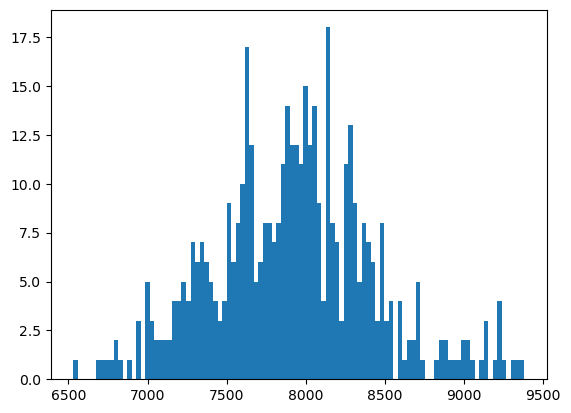

In [130]:
plt.hist(slopes[:,2],bins=100);

In [131]:
np.quantile(slopes[:,1],0.25)

nan

In [132]:
plt.hist(slope,bins=70);

NameError: name 'slope' is not defined

In [133]:
np.corrcoef(slope,cell_count)

NameError: name 'slope' is not defined

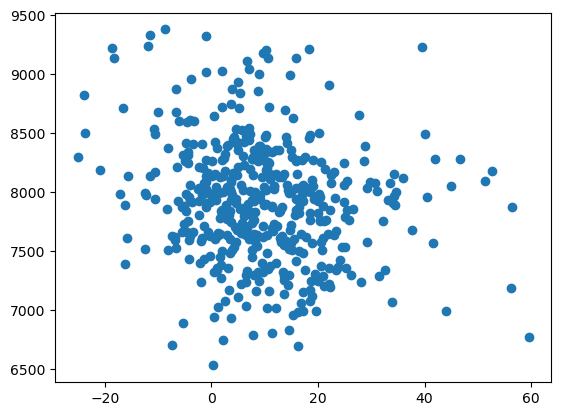

In [134]:
plt.scatter(slopes[:,0],slopes[:,2])

C:\Users\hp\AppData\Local\Temp\ipykernel_26696\4237644963.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  interpolated_data_df.groupby('id').apply(lambda x: plt.plot(x['area'].values[50:399]) if x['area'].values[50:200].min() > 6000 else None)


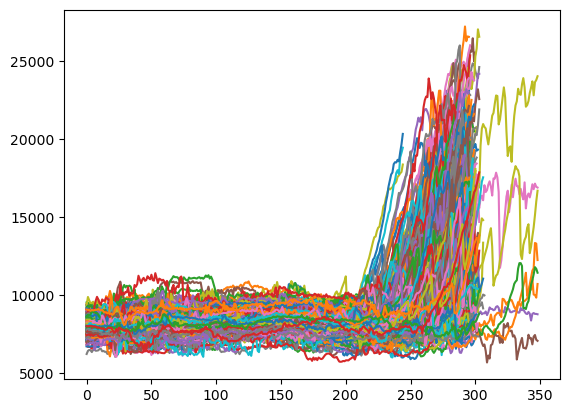

In [136]:
import matplotlib.pyplot as plt

# Create a figure and axis to ensure an empty plot is returned
fig, ax = plt.subplots()

# Apply the function and plot if the condition is met
interpolated_data_df.groupby('id').apply(lambda x: plt.plot(x['area'].values[50:399]) if x['area'].values[50:200].min() > 6000 else None)

# Show the plot
plt.show()


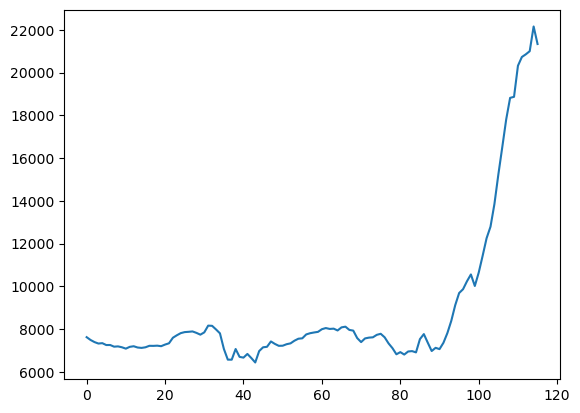

In [100]:
plt.plot(success_sample.loc[success_sample.id=='D2013.02.22_S0474_I149_1'].area.values)




<Axes: >

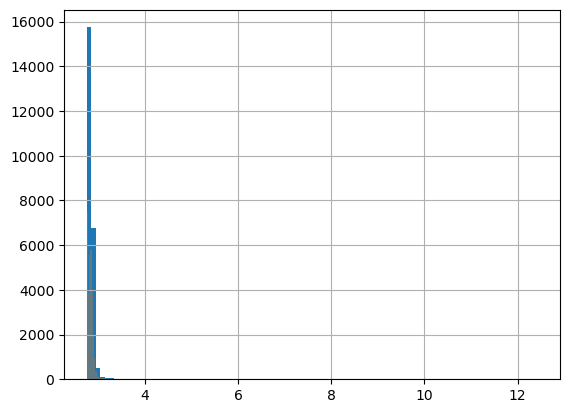

In [95]:
success_sample['solidity'].apply(lambda x: np.exp(1/x)).hist(bins=100)
fail_sample['solidity'].apply(lambda x: np.exp(1/x)).hist(bins=200,alpha=0.3)

In [160]:
success_interpol = interpolated_data_df.loc[interpolated_data_df['y']==False]

fail_interpol = interpolated_data_df.loc[interpolated_data_df['y']==True]

<Axes: >

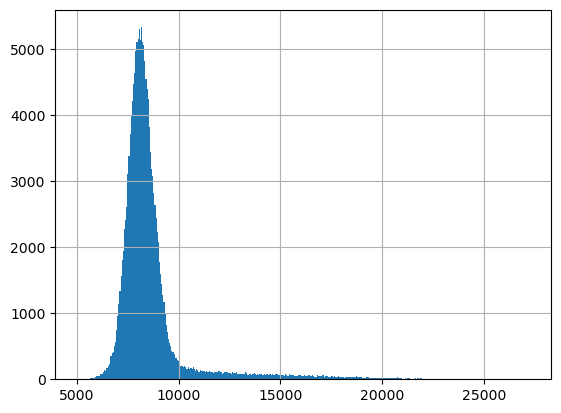

In [186]:
interpolated_data_df['area'].hist(bins=400)

<Axes: >

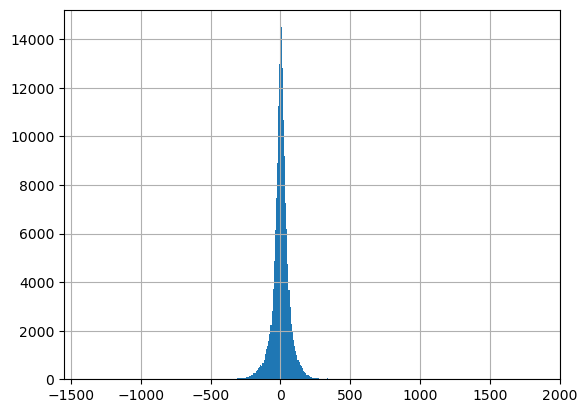

In [157]:
interpolated_data_df['inertia_tensor-0-1'].hist(bins=400)

In [200]:
q1 = success_interpol.groupby('step')[f].apply(lambda x: x.quantile(0.25))

q2 = success_interpol.groupby('step')[f].apply(lambda x: x.quantile(0.75))
mu  = success_interpol.groupby('step')[f].apply(lambda x: x.mean())

In [201]:
q1_fail = fail_interpol.groupby('step')[f].apply(lambda x: x.quantile(0.25))

q2_fail = fail_interpol.groupby('step')[f].apply(lambda x: x.quantile(0.75))
mu_fail  = fail_interpol.groupby('step')[f].apply(lambda x: x.mean())

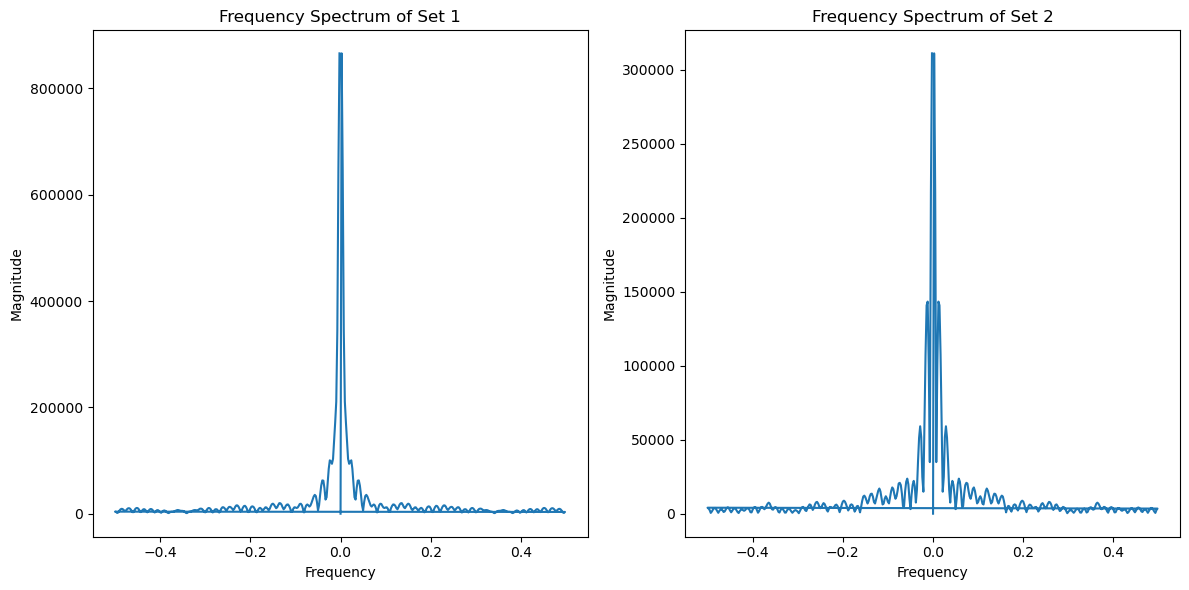

In [224]:
import numpy as np
import matplotlib.pyplot as plt

# Example time series data (replace with your data)
time_series_1 = mu- np.mean(mu)
time_series_2 = mu_fail- np.mean(mu_fail)

# Perform FFT
fft_1 = np.fft.fft(time_series_1)
fft_2 = np.fft.fft(time_series_2)

# Frequency axis
n = len(time_series_1)
freq = np.fft.fftfreq(n)

# Plot the magnitude of FFT
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(freq, np.abs(fft_1))
plt.title('Frequency Spectrum of Set 1')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')

plt.subplot(1, 2, 2)
plt.plot(freq, np.abs(fft_2))
plt.title('Frequency Spectrum of Set 2')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()


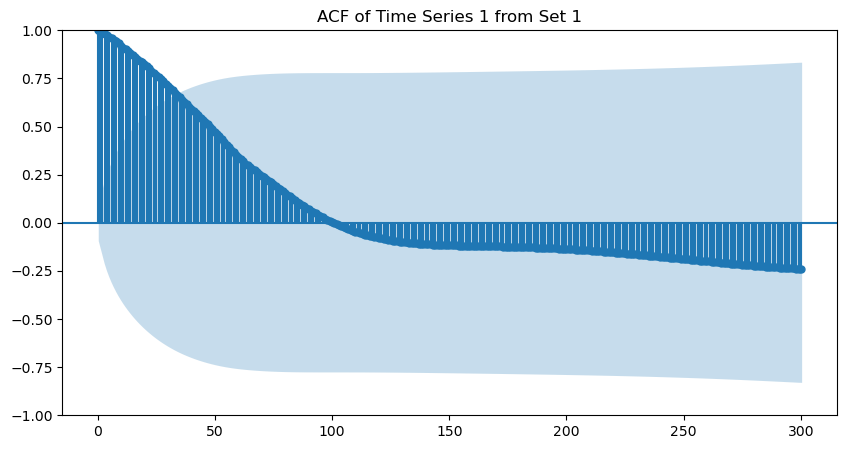

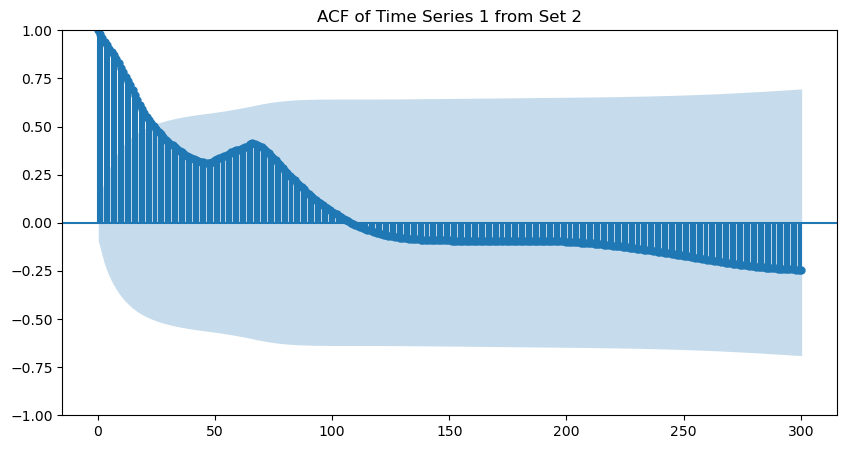

In [226]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm


# Function to plot ACF
def plot_acf(time_series, lags=300, title='Autocorrelation'):
    plt.figure(figsize=(10, 5))
    sm.graphics.tsa.plot_acf(time_series, lags=lags, ax=plt.gca())
    plt.title(title)
    plt.show()

# Compute and plot ACF for the first time series in each set
plot_acf(time_series_1, title='ACF of Time Series 1 from Set 1')
plot_acf(time_series_2, title='ACF of Time Series 1 from Set 2')

# Compute and visualize ACF for all time series in both sets
# for i in range(len(time_series_1)):

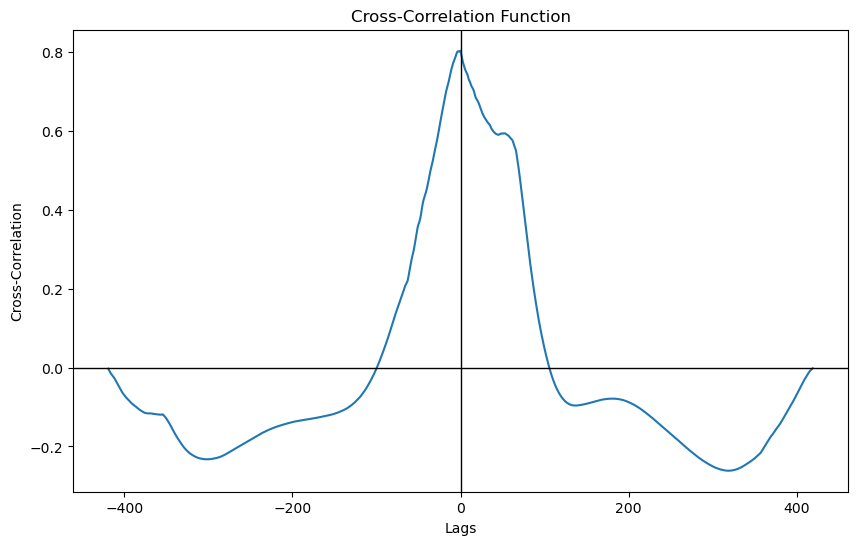

In [227]:
def cross_correlation(ts1, ts2):
    result = np.correlate(ts1 - np.mean(ts1), ts2 - np.mean(ts2), mode='full')
    return result / (np.std(ts1) * np.std(ts2) * len(ts1))

# Get cross-correlation result
ccf = cross_correlation(time_series_1, time_series_2)

# Compute lags
lags = np.arange(-len(time_series_1) + 1, len(time_series_1))

# Plot the cross-correlation function (CCF)
plt.figure(figsize=(10, 6))
plt.plot(lags, ccf)
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.title('Cross-Correlation Function')
plt.xlabel('Lags')
plt.ylabel('Cross-Correlation')
plt.show()

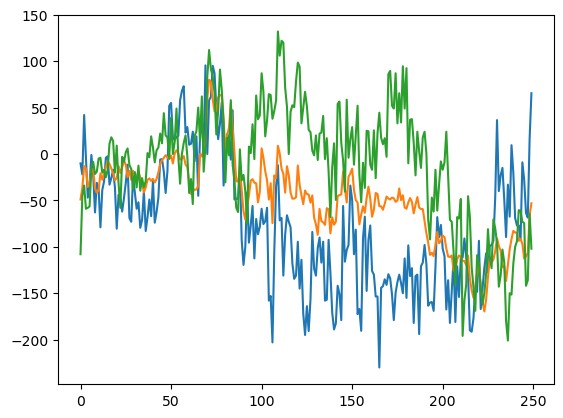

In [209]:
plt.plot(q2[:250]- q2_fail[:250])

plt.plot(mu[:250]- mu_fail[:250])
plt.plot(q1[:250]- q1_fail[:250])

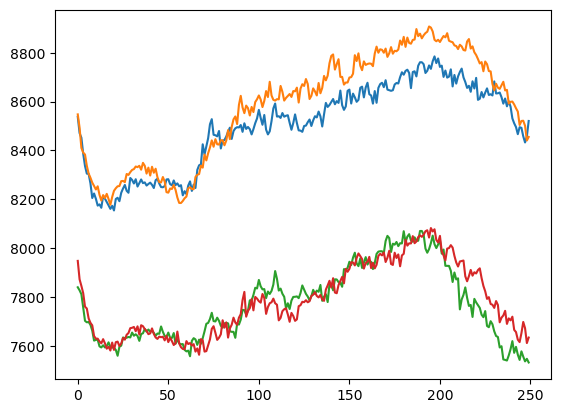

In [210]:
# plt.plot(q2)
plt.plot(q2[:250])
plt.plot(q2_fail[:250])

plt.plot(q1[:250])
plt.plot(q1_fail[:250])
# plt.plot(q1)

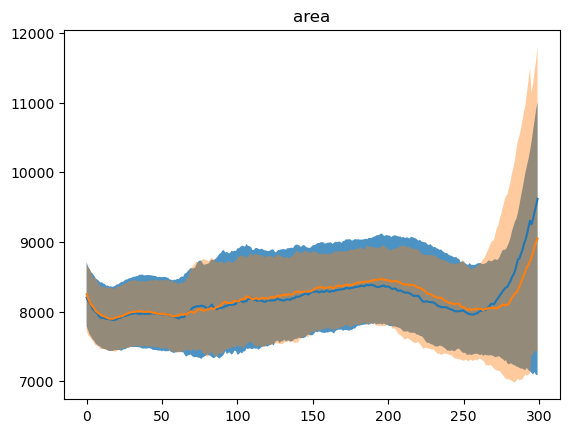

In [176]:
dn =  300
for f in features:
    success_mean = success_interpol.groupby('step')[f].apply(lambda x: x.mean())

    success_var =  success_interpol.groupby('step')[f].var()
    # success_skew = stats.skew(np.stack(success_interpol.groupby('step').apply(lambda x:  x[f].map(lambda x: x).values).tolist(),axis=0),axis=1)
    success_std = success_interpol.groupby('step')[f].apply(lambda x:x.std())
    success_q1 = success_mean+success_std#interpolated_data_df.groupby('step')[f].quantile(0.75).map(lambda x: np.exp(1/x))
    success_q2= success_mean-success_std#interpolated_data_df.groupby('step')[f].quantile(0.01).map(lambda x: np.exp(1/x))

    
    fail_mean = fail_interpol.groupby('step')[f].apply(lambda x: x.mean())
    fail_var = fail_interpol.groupby('step')[f].var()
    # fail_skew = stats.skew(np.stack(fail_interpol.groupby('step').apply(lambda x:  x[f].map(lambda x: x).values).tolist(),axis=0),axis=1)
    
    
    fail_std = fail_interpol.groupby('step')[f].apply(lambda x: x.std())
    
    fail_q1 = fail_mean+fail_std#interpolated_data_df.groupby('step')[f].quantile(0.75).map(np.log)
    fail_q2= fail_mean-fail_std#s
    # plt.scatter(fail_q1, success_q1)
    # print(np.corrcoef(fail_q1, success_q1))
    
    plt.title(f)
    # plt.show()
    plt.plot(success_mean[:dn])
    plt.plot(fail_mean[:dn])
    # plt.plot(fail_var)
    # plt.plot(success_skew)
    # # plt.plot(fail_skew)
    plt.fill_between(np.arange(0,success_q1[:dn].shape[0]), fail_q1[:dn], fail_q2[:dn], alpha=0.8,)# color='g')
    
    plt.fill_between(np.arange(0,success_q1[:dn].shape[0]), success_q1[:dn], success_q2[:dn], alpha=0.4,)# color='r')
    
    plt.show()
    break
    # break

In [ ]:
success_sample_early

In [ ]:
axs

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
success_sample_early = success_sample.loc[success_sample['step']<=120]
fail_sample_early = fail_sample.loc[fail_sample['step']<=120]
# Simulating data
np.random.seed(0)
time_steps = 120+1
series_per_class = 50
ids = np.arange(series_per_class)
fig, axs = plt.subplots(ncols=2,sharey=True, figsize=(15,12))

# Group by time_step and id to calculate mean for each time series at each step
stats_df = fail_sample_early.groupby(['step', 'id']).agg({
    'inertia_tensor-1-1': ['mean', 'median', 'std']  # Add other statistics as needed
}).reset_index()

# Unstacking for easier plotting
stats_df.columns = ['step', 'id', 'mean', 'median', 'std']
means = stats_df.pivot(index='id', columns='step', values='mean')

boxplot_data = [means[col].dropna() for col in means.columns]
axs[0].boxplot(boxplot_data)
plt.title('Box Plot of Means for Each Time Series at Each Time Step')
plt.xlabel('Time Step')
plt.ylabel('Mean Value')
# plt.show()


# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # Simulating data
# np.random.seed(0)
# time_steps = 60
# series_per_class = 50
# ids = np.arange(series_per_class)


# Group by time_step and id to calculate mean for each time series at each step
stats_df = success_sample_early.groupby(['step', 'id']).agg({
    'inertia_tensor-1-1': ['mean', 'median', 'std']  # Add other statistics as needed
}).reset_index()

# Unstacking for easier plotting
stats_df.columns = ['step', 'id', 'mean', 'median', 'std']
means = stats_df.pivot(index='id', columns='step', values='mean')

# Plotting
# plt.figure(figsize=(15, 8))
boxplot_data = [means[col].dropna() for col in means.columns]
axs[1].boxplot(boxplot_data)
# plt.title('Box Plot of Means for Each Time Series at Each Time Step')
# plt.xlabel('Time Step')
# plt.ylabel('Mean Value')
plt.show()


In [ ]:
from sklearn.decomposition import PCA

In [ ]:
y =targets

In [ ]:
X_full = np.stack(interpolated_data.fillna(0).drop(['Fetal Heart Beat', 'y'],axis=1).groupby('id').apply(lambda x: x.drop('id',axis=1).values.flatten()).tolist())


In [ ]:
y

In [ ]:
pca_failed = PCA(

In [ ]:
pca_succes = succesfull_feats.fillna(0).drop(['Fetal Heart Beat'],axis=1).groupby('id').apply(lambda x: PCA(n_components=30).fit_transform(x.drop('id',axis=1)).mean(axis=0))

In [ ]:
succesfull_feats

In [ ]:
succesfull_feats['y'] = succesfull_feats['Fetal Heart Beat']==0

In [ ]:
failed_feats['y'] = failed_feats['Fetal Heart Beat'] == 0

In [ ]:
y = pd.concat([failed_feats.drop_duplicates('id')['y'] , succesfull_feats.drop_duplicates('id')['y']])

In [ ]:
y

In [ ]:
X = np.stack([*pca_failed.tolist(),*pca_succes.tolist()])


In [ ]:
plt.scatter(X[:,0], X[:,9],c=y)

In [ ]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score

In [ ]:
X_train.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_full,y,shuffle=True, random_state=45)

In [ ]:
pca = PCA(n_components=10)


In [ ]:
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [ ]:
clf = RandomForestClassifier()

In [ ]:
clf.fit(X_train,y_train)

In [ ]:
preds = clf.predict(X_test)

In [ ]:
confusion_matrix(y_test,preds)

In [ ]:
y = np.array(y).astype(int)

In [ ]:
n_folds = KFold(5, random_state=2, shuffle=True)

preds = []

for train_idx, test_idx in n_folds.split(X_full, y):
    pca = PCA(n_components=100)
    X_train, X_test, y_train, y_test = X_full[train_idx], X_full[test_idx],y[train_idx], y[test_idx]
    clf = RandomForestClassifier(random_state=32)
    
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)

    clf.fit(X_train,y_train)

    preds = clf.predict(X_test)
    probas =clf.predict_proba(X_test)[:,1]

    print(roc_auc_score(y_test, probas))
    print(confusion_matrix(y_test,preds))

In [ ]:
zoe['embryo_id'] =  zoe['Slide ID']+'_'+zoe['Well'].astype(str)

In [ ]:
zoe['Day3 Cells'].value_counts().sum()

In [ ]:
with_grades = zoe[pd.to_numeric(zoe['Morphological Grade - Value'], errors='coerce').notnull()]

In [ ]:
with_grades['Morphological Grade - Value'].value_counts()

In [ ]:
df['id'].nunique()

In [ ]:
all_extracted.embryo_id.nunique()

In [ ]:
zoe.index = zoe['embryo_id']


In [ ]:
zoe_extracted = zoe.loc[all_extracted.embryo_id.unique()]

In [ ]:
extracted_with_grades = zoe_extracted[pd.to_numeric(zoe_extracted['Morphological Grade - Value'], errors='coerce').notnull()]

In [ ]:
all_extracted.index = all_extracted['embryo_id']


In [ ]:
all_extracted_graded = all_extracted.loc[extracted_with_grades.index]

In [ ]:
all_extracted_graded['time_hours'] = 24*all_extracted_graded.reset_index(drop=True).groupby('embryo_id').apply(lambda x: x['Time']-x['Time'].min()).values

In [ ]:
data_d2 = all_extracted_graded.loc[all_extracted_graded['time_hours']<=300]

In [ ]:
data_d2['time_hours']

In [ ]:
y = extracted_with_grades['Morphological Grade - Value']

In [ ]:
extracted_with_grades

In [ ]:

def extract_ts_features(df, column_sort, column_id, features_to_extract):
    if features_to_extract:
        extracted_features = extract_features(df,
                         column_sort=column_sort,
                         kind_to_fc_parameters=features_to_extract,
                         column_id=column_id)
    else:
        settings = EfficientFCParameters()
        extracted_features = extract_features(df,
                         column_sort=column_sort,
                          default_fc_parameters=settings,
                         column_id=column_id,n_jobs=15)
        
    return extracted_features

In [ ]:
morpho_task_keys = [
    '36_hours_morpho',
     '48_hours_morpho',
     '60_hours_morpho', 
     '72_hours_morpho',
            ]

In [ ]:
features = [
                'embryo_id', 'time_hours', 'eccentricity', 'minor_axis_length',
                'major_axis_length', 'solidity', 'area', 'area_diff',
                'major_axis_length_diff', 'eccentricity_diff',
                'minor_axis_length_diff', 'solidity_diff', 'perimeter',
                'equivalent_diameter', 'inertia_tensor-0-0',
                'inertia_tensor-0-1', 'inertia_tensor-1-0',
                'inertia_tensor-1-1'
            ]

In [ ]:
new_df = data_d2.copy()

In [ ]:
new_cols = []
for c in features[1:]:
    new_df = new_df[pd.to_numeric(
        new_df[c],
        errors='coerce').notnull()]
    

In [ ]:
new_df[features[1:]] = new_df[features[1:]].astype(float)

In [ ]:
new_df = new_df.fillna(0)

In [ ]:
# extracted_features_d2 = extract_ts_features(new_df[features].reset_index(drop=True),
#                                             column_sort='time_hours',
#                                            column_id='embryo_id'
#                                             ,features_to_extract=None)

In [ ]:
from darts.models.forecasting.tide_model import TiDEModel


In [ ]:
long_enough_ids = new_df.index.unique()[new_df.groupby(new_df.index).time_hours.max()>100][:4000]

In [ ]:
from darts import TimeSeries

In [ ]:
features = ['area', 'eccentricity',
       'equivalent_diameter', 'inertia_tensor-0-0', 'inertia_tensor-0-1',
       'inertia_tensor-1-0', 'inertia_tensor-1-1', 'major_axis_length',
       'minor_axis_length', 'perimeter', 'solidity', 'area_diff',
       'eccentricity_diff', 'minor_axis_length_diff', 'major_axis_length_diff',
       'solidity_diff', 'time_hours']

In [ ]:
starting_time = pd.to_datetime('2010-01-10')

In [ ]:
df__['time']+starting_time

In [ ]:
all_timeseries = []
for id_ in long_enough_ids:
    df__=new_df.copy().loc[id_]
    df__['time']= pd.to_timedelta(df__['time_hours'], unit='h')+starting_time

    df__ = df__.set_index('time')
    df__ = df__[features].resample('20min').mean()
    ts = TimeSeries.from_dataframe(df__.reset_index(),
                                  time_col='time',
                                   # fill_missing_dates=True, 
                                   freq='20min')
    if len(ts)<340:
        
        continue

    if len(ts)>381:
        continue
    all_timeseries.append(ts)
    

In [ ]:
len(all_timeseries)

In [ ]:
all_timeseries[30]['area'].plot()


In [ ]:
all_timeseries[0].resample('1min')

In [ ]:
from darts.utils.missing_values import fill_missing_values

In [ ]:
from darts.dataprocessing.transformers import Scaler

from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
all_timeseries = [fill_missing_values(t) for t in all_timeseries]

In [ ]:
scaler = Scaler(StandardScaler())

In [ ]:
train_len = int(0.8*len(all_timeseries))


train_ts = scaler.fit_transform(all_timeseries[:train_len])

val_ts = scaler.transform(all_timeseries[train_len:])

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping
import torch

In [ ]:
optimizer_kwargs = {
        "lr": 3e-5,
    }

my_stopper = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=0.0001,
    mode='min',
    
)
# pl_trainer_kwargs = {"callbacks": [my_stopper]}
# 
# PyTorch Lightning Trainer arguments
pl_trainer_kwargs = {
    "gradient_clip_val": 1e3,
    "max_epochs": 100,
    "accelerator": "gpu",
    "devices": [1],
    "callbacks": [my_stopper],
}

# learning rate scheduler
lr_scheduler_cls = torch.optim.lr_scheduler.CosineAnnealingLR
lr_scheduler_kwargs = {
    "T_max":30*36887
    # "gamma": 0.999,
}

# early stopping (needs to be reset for each model later on)
# this setting stops training once the the validation loss has not decreased by more than 1e-3 for 10 epochs
early_stopping_args = {
    "monitor": "val_loss",
    "patience": 5,
    "min_delta": 1e-5,
    "mode": "min",
} 

common_model_args = {
    "input_chunk_length": 250,  # lookback window
    "output_chunk_length": 80,  # forecast/lookahead window
    "optimizer_kwargs": optimizer_kwargs,
    "pl_trainer_kwargs": pl_trainer_kwargs,
    "lr_scheduler_cls": lr_scheduler_cls,
    "lr_scheduler_kwargs": lr_scheduler_kwargs,
    # "likelihood": LaplaceLikelihood(prior_b=1),
    "save_checkpoints": True,  # checkpoint to retrieve the best performing model state,
    "force_reset": True,
    "batch_size": 32,
    "random_state": 1024,
    "dropout": 0.0,
    "log_tensorboard": True 
}


from uuid import uuid4
model_uuid = uuid4()

# print(model_uuid)
model = TiDEModel(
    **common_model_args,
    model_name=f"tide_{model_uuid}",
    hidden_size=512,
    decoder_output_dim=8,
    temporal_decoder_hidden=16,
    use_layer_norm=True,
    n_epochs=100,
use_reversible_instance_norm=True
    # add_encoders=add_encoders
        # n_epochs=10#,use_reversible_instance_norm=True
    )


model.fit(train_ts, val_series=val_ts)

In [ ]:
val_ts[-1][:350]['area']

In [ ]:
for val in val_ts:
    model.predict(80,val[:250])[features[0]].plot()
    val[:500][features[0]].plot()
    plt.show()

In [ ]:
model.predict(10000,val_ts[-3][:250])[features[0]].plot()
val_ts[-3][:350][features[0]].plot()

In [ ]:
model.predict(150,scaler.transform(all_timeseries[-1])[:250])['area'].plot()
scaler.transform(all_timeseries[-1][:350])['area'].plot()

In [ ]:
from darts.datasets import WeatherDataset
from darts.models import TCNModel
series = WeatherDataset().load()
# predicting atmospheric pressure
target = series['p (mbar)'][:100]
# optionally, use past observed rainfall (pretending to be unknown beyond index 100)
past_cov = series['rain (mm)'][:100]
# `output_chunk_length` must be strictly smaller than `input_chunk_length`
model = TCNModel(
    input_chunk_length=12,
    output_chunk_length=6,
    n_epochs=20,
)
model.fit(target, past_covariates=past_cov)
pred = model.predict(6)

In [ ]:
series

In [ ]:
from  datetime import datetime

In [ ]:
datetime.fromtimestamp(40695.637367*100*60)

In [ ]:
?datetime.fromtimestamp

In [ ]:
merged_r_alligned['area_diff'] = merged_r_alligned.groupby('id').area.diff().fillna(0)
merged_r_alligned['solidity_diff'] = merged_r_alligned.groupby('id').solidity.diff().fillna(0)
merged_r_alligned['eccentricity_diff'] = merged_r_alligned.groupby('id').eccentricity.diff().fillna(0)
merged_r_alligned['major_axis_length_diff'] = merged_r_alligned.groupby('id').major_axis_length.diff().fillna(0)
merged_r_alligned['minor_axis_length_diff'] = merged_r_alligned.groupby('id').minor_axis_length.diff().fillna(0)

In [ ]:
merged_r_alligned[features]

In [ ]:
timestep_per_morpho_task = {}
for morpho_task in morpho_task_keys:
    step = 12
    total_t = morpho_task.split('_')[0]
    dts = [(i,i+step) for i in range(0,int(1*total_t), step)]
    timestep_per_morpho_task[morpho_task] = dts
    

In [ ]:
from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters
settings = EfficientFCParameters()
#settings = MinimalFCParameters()
# Set here the options of the settings object as shown in the paragraphs below
from tsfresh.feature_extraction import extract_features

extracted_feats_per_timestep = {}
step = 12
total_t = 72
all_dts = [(i,i+step) for i in range(0,int(1*total_t), step)]

for dt in dts:
    msk = (24*merged_r_alligned.Time<=dt[1])&(24*merged_r_alligned.Time>dt[0])
    df_masked = merged_r_alligned.loc[msk][features].fillna(0)
    extracted_features = extract_ts_features(df=df_masked,
                        column_sort='Time',
                        column_id='id',
                        features_to_extract=None
                       )

    extracted_features.columns = [f"{c}__{dt}" for c in extracted_features.columns]
    extracted_feats_per_timestep[f"{dt}"] = extracted_features

In [ ]:
extracted_feats_per_task = {}
for key, dts in timestep_per_morpho_task.items():
    task_df = pd.concat([extracted_feats_per_timestep[f"{dt}"] for dt in dts], axis=1)
    extracted_feats_per_task[key] = task_df

In [ ]:
import pickle
blasto_settings = pickle.load(open('trained_models/features_to_extract_tsfresh.pkl', 'rb'))

In [ ]:
extracted_features_blasto = extract_ts_features(df=merged_r_alligned[features].fillna(0),
                        column_sort='Time',
                        column_id='id',
                        features_to_extract=blasto_settings
                       )

In [ ]:
blasto_target

In [ ]:
y_area = blasto_target.loc[extracted_features_blasto.index]

In [ ]:
merged_r_alligned

In [ ]:
a = pd.Series(y_area.index.map(with_grades['Fetal Heart Beat']))

In [ ]:
{'Fetal Heart Beat':a, 'id' :y_area.index}

In [ ]:
final_result_df = pd.DataFrame({'Fetal Heart Beat':a, 'id' :y_area.index}).dropna()

In [ ]:
final_result_df['Fetal Heart Beat'].value_counts()

In [ ]:
msk1 = (final_result_df['Fetal Heart Beat']!='Unknown')
msk2 = (final_result_df['Fetal Heart Beat']!='unknown')
final_result_df['Fetal Heart Beat'] = final_result_df['Fetal Heart Beat'].replace('Unknown', 0)
final_result_df['Fetal Heart Beat'] = final_result_df['Fetal Heart Beat'].replace('unknown', 0)
# final_result_df = final_result_df.loc[msk1]
# final_result_df = final_result_df.loc[msk2]

In [ ]:
msk1

In [ ]:
final_result_df

In [ ]:
test_ids = final_result_df.id.values

In [ ]:
train_ids = [id_ for id_ in y_area.index if id_ not in test_ids]

In [ ]:
 merged_r_alligned.reset_index(drop=True).groupby('id')\
    .apply(lambda x: x.group_grade.values[0]).loc[y_area.index].value_counts()

In [ ]:
y_grade = merged_r_alligned.reset_index(drop=True).groupby('id').apply(lambda x: x.group_grade.values[0])

In [ ]:
y_grade_train = y_grade.loc[train_ids]

y_grade_test = y_grade.loc[test_ids]


In [ ]:
extra_bads_test = y_grade_train.loc[y_grade_train=='Bad'].sample(46)
extra_best_train = y_grade_test.loc[y_grade_test=='Best'].sample(46)


In [ ]:
y_grade_train = y_grade_train.drop(extra_bads_test.index)
y_grade_train = pd.concat([y_grade_train, extra_best_train])

y_grade_test = y_grade_test.drop(extra_best_train.index)
y_grade_test = pd.concat([y_grade_test, extra_bads_test])

In [ ]:
train_ids = y_grade_train.index
test_ids = y_grade_test.index

In [ ]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score

In [ ]:
X = timesteps_features.drop('group_grade',axis=1).iloc[:,:-1].fillna(0)
y = timesteps_features['group_grade'].fillna('Bad')=='Bad'

In [ ]:
X_train.shape[0], X_test.shape[0]

In [ ]:
y_train.shape[0], y_test.shape[0]

In [ ]:
kfolds = KFold(5)

In [ ]:
import lightgbm as lgb
from sklearn.metrics import confusion_matrix,roc_auc_score, accuracy_score
from tqdm import tqdm

In [ ]:
def train_classifier(clf, X, y):
    kfolds = KFold(5)
    import_feats = []
    clfs = []
    aucs = []
    count = 1
    for train, test in tqdm(kfolds.split(X_train, y_train)):
        #clf = RandomForestClassifier(n_jobs=-1)
        clf.fit(X_train.iloc[train].values, y_train.iloc[train])
        pred_porba = clf.predict_proba(X_train.iloc[test].values)

        clfs.append(clfs)
        import_feats.extend(list(np.argsort(clf.feature_importances_)[-600:]))
        auc = roc_auc_score(y_train.iloc[test], pred_porba[:,1])
        preds = clf.predict(X_train.iloc[test].values)
       # auc = confusion_matrix(y_train.iloc[test], preds)
       # print(auc)
        aucs.append(auc)
        #count+=1
    #print(f"Fold {count}")
    print(f"AUC: {np.mean(aucs)} +-{np.std(aucs)}")
       
    return list(set(import_feats))

In [ ]:
from random import shuffle
from tqdm import tqdm
shuffle(list(train_ids))

In [ ]:
blasto_target = blasto_target.fillna(8000)
extracted_features_blasto = extracted_features_blasto.fillna(0)

In [ ]:
y_area_target = blasto_target>2000

In [ ]:
blasto_target.diff().hist()

In [ ]:
y_train_blasto

In [ ]:
predictions_per_task = {}
feats_per_task = {}
for morpho_task in morpho_task_keys:
    print(morpho_task)
    clf = RandomForestClassifier(n_jobs=-1)
    
    X = extracted_feats_per_task[morpho_task].fillna(0)
    train_ids_lst = list(train_ids)
    shuffle(train_ids_lst)
    
    X_train, X_test = X.loc[train_ids_lst],  X.loc[test_ids]
    y_train =  y_area_target.loc[train_ids_lst]#.fillna('Bad')!='Bad'
    feats = train_classifier(clf, X_train, y_train)
    feats_per_task[morpho_task] = feats
    
    clf.fit(X_train.iloc[:,feats], y_train)
    
    predictions_per_task[morpho_task] = clf.predict_proba(X_test.iloc[:,feats])[:,1]
        


X_train, X_test = extracted_features_blasto.loc[train_ids_lst],  extracted_features_blasto.loc[test_ids]
y_train_blasto = blasto_target.loc[train_ids]
regr = RandomForestRegressor(n_jobs=-1)
regr.fit(X_train, y_train_blasto)

predictions_per_task["blasto_stage"] = regr.predict(X_test)

In [ ]:
y_train.sum()

In [ ]:
all_predictions = pd.DataFrame(predictions_per_task)

In [ ]:
all_predictions.index = test_ids

In [ ]:
final_result_df.index = final_result_df.id

In [ ]:
all_predictions['blasto_stage']


In [ ]:
from sklearn.metrics import f1_score, classification_report
threshs = np.linspace(0,.999,1000)
for task in all_predictions.columns:
    f1s = []
    for thresh in threshs:
        f1s.append(f1_score(y_grade_test!='72_hours_morpho', all_predictions[task]>thresh))
    
    best_thresh = threshs[np.argmax(f1s)]
    print(confusion_matrix(y_grade_test!='Bad', all_predictions[task]>best_thresh))
    print(max(f1s))


In [ ]:
mean_preds = all_predictions[morpho_task_keys].mean(axis=1)

In [ ]:
plt.hist(mean_preds)

In [ ]:
roc_auc_score(y_grade_test!='Bad',mean_preds)

In [ ]:
f1s = []
threshs = np.linspace(0,.7,500)
for thresh in threshs:
    f1s.append(f1_score(y_grade_test!='Bad', mean_preds>thresh))

best_thresh = threshs[np.argmax(f1s)]
print(confusion_matrix(y_grade_test!='Bad', mean_preds>best_thresh))

In [ ]:
best_thresh

In [ ]:
print(confusion_matrix(y_grade_test!='Bad', mean_preds>.7))

In [ ]:
final_result_df

In [ ]:
fetal_heart =  final_result_df.loc[all_predictions.index]['Fetal Heart Beat']

In [ ]:
pred_good = fetal_heart.loc[mean_preds>.7].dropna()
pred_bad = fetal_heart.loc[mean_preds<.7].dropna()

In [ ]:
pred_good

In [ ]:
104+79

In [ ]:
104/183

In [ ]:
(pred_bad>0).value_counts()

In [ ]:
23/35

In [ ]:
final_result_df_clean = y_grade_test#with_grades.loc[all_predictions.index]['Fetal Heart Beat'].dropna()

In [ ]:
final_result_df_clean = final_result_df_clean.replace(2,1)
final_result_df_clean = final_result_df_clean.replace(3,1)

In [ ]:
X_final, y_final = all_predictions.loc[final_result_df_clean.index], final_result_df_clean

In [ ]:
y_final = y_grade.loc[y_final.index]#!='Bad'

In [ ]:
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y_final)

In [ ]:
from sklearn.linear_model import LogisticRegression, BayesianRidge, SGDClassifier, Perceptron

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC

In [ ]:
clf = RandomForestClassifier()

scaler = StandardScaler()

clf.fit(X_train_final, y_train_final)
probas_final = clf.predict_proba(X_test_final)

In [ ]:
probas_final

In [ ]:
decisions = with_grades.loc[y_grade_test.index]['Decision']

In [ ]:
decisions = decisions.loc[decisions!='Not decided']
decisions = decisions.loc[decisions!='Freeze']

In [ ]:
X_final['36_hours_morpho']

In [ ]:
from
accuracy_score(y_grade_test!='Bad', X_final['36_hours_morpho'])

In [ ]:
roc_auc_score(y_grade_test!='Bad', X_final['48_hours_morpho'])

In [ ]:
roc_auc_score(y_grade_test!='Bad', X_final['60_hours_morpho'])

In [ ]:
roc_auc_score(y_grade_test!='Bad', X_final['72_hours_morpho'])

In [ ]:
roc_auc_score(y_grade_test!='Bad', X_final['48_hours_morpho'])

In [ ]:
preds = clf.predict_proba(X_test.values[:,final_feats])

In [ ]:
print(roc_auc_score(y_test, preds[:,1]))

In [ ]:
[c.split('_')[-1] for c in X_test.iloc[:,final_feats].columns]

In [ ]:
import shap
shap_values = shap.TreeExplainer(clf).shap_values(X_test.iloc[:,final_feats])
shap.summary_plot(shap_values[0], X_test.iloc[:,final_feats])

In [ ]:
for c in X_test.iloc[:,final_feats].columns:
    print(c)
    shap.dependence_plot(c, shap_values[0], X_test.iloc[:,final_feats])


In [ ]:
>>> import numpy as np
>>> from sklearn.linear_model import SGDClassifier
>>> from sklearn.preprocessing import StandardScaler
>>> from sklearn.pipeline import make_pipeline
>>> X = np.array([[-1, -1], [-2, -1], [1, 1], [2, 1]])
>>> Y = np.array([1, 1, 2, 2])
>>> # Always scale the input. The most convenient way is to use a pipeline.
>>> clf = SGDClassifier(max_iter=1000, tol=1e-3)
...                     
>>> clf.fit(X, Y)
print(clf.predict([[-0.8, -1]]))


In [ ]:
clf.densify()

In [ ]:
all_resampled = []
from tqdm import tqdm
for id_ in tqdm(ids):
    emb_dict = {}
    t_id = id_
    data = merged_r.loc[merged_r.id==id_]
    print('Time steps: ', data.shape[0])
    print('hours: ', 24*data.Time.max())
    for i, t in enumerate(options):

        temp = pd.DataFrame(columns=[t])
        
        temp[t] = data[t]#.rolling(5).mean()
        index = pd.date_range('00:00:00',periods=data[t].shape[0], freq='T')
        series = pd.Series(data[t].values, index=index)
        if series.shape[0] <500:
            inter = series.resample(f'{len(series)/501:.3f}T').mean()#.interpolate(method='linear')
            
            plt.plot(series.resample(f'{len(series)/501:.3f}T').interpolate(method='linear'))
            plt.plot(inter.interpolate(method='linear'))
            plt.show()
        else:
            try:
                inter = series.resample(f'{len(series)/500:.3f}T').mean()
            except:
                print(id_)
                print(series.shape)
                continue
        emb_dict[t] = inter
    all_resampled.append(emb_dict)

In [ ]:
inter = series.resample(f'.95T').mean().interpolate(method='linear')

In [ ]:
print(inter.shape)

In [ ]:
plt.plot(inter)

In [ ]:
# merged_r = df.merge(with_grades.reset_index(drop=True), left_on='id', right_on='id')

In [ ]:
merged_r

In [ ]:
merged_.id.nunique()

In [ ]:
inlcusive_ids = [i for i in list(df.id.unique()) if i in list(with_grades['id'].values)]

In [ ]:
len(inlcusive_ids)

In [ ]:
with_grades.loc[inlcusive_ids]['group_grade']=='Best'
with_grades.loc[inlcusive_ids]['group_grade']=='Medium'
with_grades.loc[inlcusive_ids]['group_grade']=='Bad'
with_grades.loc[inlcusive_ids]['group_grade']=='Worse'

In [ ]:
from scipy import stats
def q1(x):
    q_low = x.quantile(0.01)
    q_hi  = x.quantile(0.99)
    print(x)
    return x.loc[(x < q_hi) & (x > q_low)]

In [ ]:
all_feats = [
            'tPNf',
            't2',
            't3',
            't4',
            't5',
            't6',
            't2-tPNf',
            't3-tPNf',
            't4-tPNf',
            't5-tPNf',
            't3-t2',
            't4-t2',
            't4-t3',
            't5-t3',
            't5-t4',
            't6-t2',
            't6-t3',
            't6-t4',
            't6-t5',
        ]


In [ ]:
with_grades[['t2','t6']].info()

In [ ]:
aggregated_data = pd.pivot_table(
                with_grades, 
                values=all_feats,
                index=['group_grade'],
                aggfunc=[np.mean, np.std]
              )

upper = aggregated_data.columns.get_level_values(0)
lower = aggregated_data.columns.get_level_values(1)
aggregated_data.columns = [f"{j}_{i}" for i, j in zip(upper,lower)]

In [ ]:
aggregated_data.columns = [f"{j}_{i}" for i, j in zip(upper,lower)]
#aggregated_data.columns = [' '.join(col).strip() for col in aggregated_data.columns.values]

In [ ]:
 aggregated_data.reset_index().to_csv('aggregated_grades.csv')

In [ ]:
import json

In [ ]:
import json
with open('aggregated_grades.json', 'w') as f:
    json.dump(aggregated_data.to_json(), f)

In [ ]:
json.parse(aggregated_data.to_json())

In [ ]:
%%time
j = pd.read_csv('aggregated_grades.csv')
print(j.loc[j['group_grade']=='Bad','t2_mean'])

In [ ]:
def load_json():
    with open('aggregated_grades.json', 'rb') as f:
        j = json.loads(json.load(f))
        t = j['t2_mean']['Bad']

def load_csv():
    j = pd.read_csv('aggregated_grades.csv')
    t = j.loc[j['group_grade']=='Bad','t2_mean']

In [ ]:
%timeit load_json()

In [ ]:
%timeit load_csv()

In [ ]:
columns = ['id', 'tPNf', 't2', 't3', 't4', 't5', 't6', 'Dynamic Score - Time',
          'Dynamic Score - Value' ,
           'Morphological Grade - Time', 
           'Grade at approx. 65h - Zoe',
          'Day3 Grade', 'Day3 Cells', 
           'Fragmentation - Time 1',
        'Fragmentation - Value 1',
           'Multi Nucleation - Time 1',
        'Multi Nucleation - Value 1',
          'Blastomere Size - Time 1',
        'Blastomere Size - Value 1',
           'Pronuclei - Time 1',
          'Pronuclei - Value 1']

In [ ]:
df.drop_duplicates('id', keep='first')

In [ ]:
target['Morphological Grade - Value'].hist()

In [ ]:
graded_embryoscope = pd.merge(target, zoe[columns].drop_duplicates('id', keep='first'), on='id', how='left')

In [ ]:
whole = pd.merge(df.drop_duplicates('id', keep='first'), graded_embryoscope, on='id', how='left')

In [ ]:
#target = testing.groupby('id').apply(lambda x: x['Morphological Grade - Value'].iloc[0])

In [ ]:
extra_feats_cols = ['id', 'Morphological Grade - Value', 'tPNf', 't2', 't3', 't4', 't5', 't6',
       'Dynamic Score - Time', 
       'Morphological Grade - Time', 
      'Fragmentation - Time 1',
       'Fragmentation - Value 1', 'Multi Nucleation - Time 1',
       'Multi Nucleation - Value 1', 'Blastomere Size - Time 1',
       'Blastomere Size - Value 1', 'Pronuclei - Time 1',
       'Pronuclei - Value 1']

In [ ]:
extra_feats = whole[extra_feats_cols].fillna(value=whole[extra_feats_cols].mean())

In [ ]:
extra_feats['diff_65'] = extra_feats['t6'] - extra_feats['t5']
extra_feats['diff_64'] = extra_feats['t6'] - extra_feats['t4']
extra_feats['diff_63'] = extra_feats['t6'] - extra_feats['t3']
extra_feats['diff_62'] = extra_feats['t6'] - extra_feats['t2']
extra_feats['diff_61'] = extra_feats['t6'] - extra_feats['tPNf']

extra_feats['diff_54'] = extra_feats['t5'] - extra_feats['t4']
extra_feats['diff_53'] = extra_feats['t5'] - extra_feats['t3']
extra_feats['diff_52'] = extra_feats['t5'] - extra_feats['t2']
extra_feats['diff_51'] = extra_feats['t5'] - extra_feats['tPNf']


extra_feats['diff_43'] = extra_feats['t4'] - extra_feats['t3']
extra_feats['diff_42'] = extra_feats['t4'] - extra_feats['t2']
extra_feats['diff_41'] = extra_feats['t4'] - extra_feats['tPNf']

extra_feats['diff_32'] = extra_feats['t3'] - extra_feats['t2']
extra_feats['diff_31'] = extra_feats['t3'] - extra_feats['tPNf']

extra_feats['diff_21'] = extra_feats['t2'] - extra_feats['tPNf']


In [ ]:
#df_pixel = pd.read_csv('pixel_features.csv')

In [ ]:
#df_pixel.shape

In [ ]:
#df = pd.merge(df, df_pixel,'inner', on=['id','t'])

In [ ]:
%matplotlib inline
for col in df.columns:
    try:
        plt.hist(df[col], bins=200)
        plt.title(col)
        plt.show()
    except:
        pass

In [ ]:
timesteps = pd.read_csv('../files/grade_timesteps.csv')

In [ ]:
df.info()

In [ ]:
timesteps

In [ ]:
target['Morphological Grade - Value'].value_counts().sum()

In [ ]:
import gc
gc.collect()

In [ ]:
dts = timesteps.groupby('id').apply(lambda x: x.dt.diff().mean())

In [ ]:
dts.hist()

In [ ]:
timesteps.index = timesteps.id

In [ ]:
time

In [ ]:
df = df.reset_index(drop=True)
df['DT'] = df.id.map(dts)

In [ ]:
df['Time'] = df.groupby('id').DT.cumsum()

In [ ]:
#test['Time'] = test.groupby('id').apply(lambda x: x['0'].cumsum()).reset_index(drop=True)

In [ ]:
%matplotlib inline
df.groupby('id').apply(lambda x: x['Time'].max()).reset_index(drop=True)

In [ ]:
import gc
gc.collect()

In [ ]:
zoe.index = zoe.id

In [ ]:
all_feats = [
            'tPNf',
            't2',
            't3',
            't4',
            't5',
            't6',
            't2-tPNf',
            't3-tPNf',
            't4-tPNf',
            't5-tPNf',
            't3-t2',
            't4-t2',
            't4-t3',
            't5-t3',
            't5-t4',
            't6-t2',
            't6-t3',
            't6-t4',
            't6-t5',
        ]

In [ ]:
find_outcomes = zoe.loc[df.id.unique()]

In [ ]:
find_outcomes['Gestational Sacs'].

In [ ]:
succesful =  find_outcomes.loc[find_outcomes['Fetal Heart Beat']==1]
unsuccesful =  find_outcomes.loc[find_outcomes['Fetal Heart Beat']==0]

In [ ]:
pd.concat([succesful, unsuccesful])[['Well', 'Slide ID', 'Fetal Heart Beat', 'Morphological Grade - Value']]

In [ ]:
find_outcomes

In [ ]:
zoe

In [ ]:
df['id'] = LabelEncoder().fit_transform(df['id'])

In [ ]:
df = df.fillna(value=df.mean())


In [ ]:
df = df.dropna(axis=1)

In [ ]:
#df = df.groupby('id').apply(lambda x: x.iloc[:300]).reset_index(drop=True)

In [ ]:
df.groupby('id')

In [ ]:
def drop_empty(x):
    area = x.area.values
    if area.min()>3000:
        return x
    
def get_small_t(x):
    if x.Time.iloc[-1]>3:
        return x

def drop_no_fert(x):
    if x.area.values[-1]>5500:
        return x

def drop_early(x):
    if x.Time.max()>4.65:
        return x

In [ ]:
test = df.groupby('id').apply(get_small_t).reset_index(drop=True)
clean = test.groupby('id').apply(drop_empty).reset_index(drop=True)
#clean = clean.groupby('id').apply(drop_no_fert).reset_index(drop=True)
clean = clean.groupby('id').apply(drop_early).reset_index(drop=True)
target_area = clean.groupby('id').apply(lambda x: x.loc[x.Time>4.65].area.iloc[0])
#target_means = clean.groupby('id').apply(lambda x: x.loc[x.Time>4.65].means.iloc[0])


In [ ]:
for c in clean.columns[1:-4]:
    print(c, clean[c].var())
    plt.hist(clean[c],bins=100)
    
    plt.show()

In [ ]:
clean.columns[1:-4]

In [ ]:
features_list = ['area', 'eccentricity', 'equivalent_diameter', 'inertia_tensor-0-0',
       'inertia_tensor-0-1', 'inertia_tensor-1-0', 'inertia_tensor-1-1',
       'major_axis_length', 'minor_axis_length',  'perimeter',
       'solidity', 'Time',]

In [ ]:
def resample_(x):
    period = '30min'
    new_df = pd.DataFrame()
    
    for c in x.columns:
        if c!='id':
            ts = x.loc[x['Time']<=6][c]

            ts.index = pd.DatetimeIndex(x.loc[x['Time']<=6]['Time']*8.64e+13)
            ts = ts.resample('30min').mean()
            new_df[c] = ts
        else:
            continue
    return new_df


resampled_df = clean[['id']+features_list].groupby('id').apply(resample_)

resampled_df['Time_1'] = resampled_df['Time']
del resampled_df['Time']

resampled_df = resampled_df.reset_index()
resampled_df['Time_1'] = resampled_df['Time_1']-0.01043



In [ ]:
#%debug

In [ ]:
count = 0
%matplotlib inline
count_big = 0
count_small = 0 
for g, val in resampled_df.groupby('id'):
   # if val.area.values[-1]>5500:
    filt = (val['Time_1']<=3.5)&(val['Time_1']>=1)
    ts = val.loc[filt]['area']
    ts.index = pd.DatetimeIndex(val.loc[filt]['Time_1']*8.64e+13)
    
    if ts.max()>12000:
        
        plt.plot(ts,marker='+', linewidth=1)
        #plt.show()
        count_big+=1
    else:
        
        plt.plot(ts,marker='*', linewidth=1)
        
        count_small+=1
    
    if (count_small>10)&(count_big>10):
        continue
plt.show()

In [ ]:

X_ = resampled_df.groupby('id').apply(lambda x: x.loc[x.Time_1<4]).reset_index(drop=True)


In [ ]:
area_35 = X_.groupby('id').apply(lambda x: x.area.iloc[-1])

In [ ]:
#resampled_df.to_csv('resampled_data_30_min.csv', index=False)

In [ ]:
%matplotlib inline
for idx, g in resampled_df.groupby('id'):
    #print(g['Weeks'].shape[0])
    plt.plot(g['Time'], g['area'])

In [ ]:
%matplotlib inline
diff.hist(bins=100)

In [ ]:
target_area.hist(bins=100)

In [ ]:
target_area = resampled_df.groupby('id').apply(lambda x: x.loc[x.Time_1>4.5].area.mean())
diff = target_area - area_35

In [ ]:
resampled_df.id.nunique()

In [ ]:
%matplotlib inline
target_area.hist(bins=100)

In [ ]:
%matplotlib inline
target_area.hist(bins=100)

In [ ]:
diff = target_area- clean.groupby('id').apply(lambda x: x.iloc[0].area)

In [ ]:
X_

In [ ]:
features_list

In [ ]:
X_['area_diff'] = X_.groupby('id').area.diff()
X_['solidity_diff'] = X_.groupby('id').solidity.diff()
X_['eccentricity_diff'] = X_.groupby('id').eccentricity.diff()
X_['equivalent_diameter_diff'] = X_.groupby('id').equivalent_diameter.diff()
X_['major_axis_length_diff'] = X_.groupby('id').major_axis_length.diff()
X_['minor_axis_length_diff'] = X_.groupby('id').minor_axis_length.diff()
X_['inertia_tensor-0-1_diff'] = X_.groupby('id')['inertia_tensor-0-1'].diff()
X_['inertia_tensor-0-0_diff'] = X_.groupby('id')['inertia_tensor-0-0'].diff()
X_['inertia_tensor-1-0_diff'] = X_.groupby('id')['inertia_tensor-1-0'].diff()
X_['inertia_tensor-1-1_diff'] = X_.groupby('id')['inertia_tensor-1-1'].diff()

X_ = X_.fillna(0)

In [ ]:
X_.id.nunique()

In [ ]:
features_list = ['eccentricity','minor_axis_length', 'major_axis_length',
                 'area','area_diff', 'solidity_diff',
       'eccentricity_diff', 'equivalent_diameter_diff',
       'major_axis_length_diff', 'minor_axis_length_diff',
       'inertia_tensor-0-1_diff', 'inertia_tensor-0-0_diff',
       'inertia_tensor-1-0_diff', 'inertia_tensor-1-1_diff', 'Time_1',]
'''
'means', 'std',
'equivalent_diameter', 'inertia_tensor-0-0',
                'inertia_tensor-1-1', 'perimeter', 'convex_area', 'moments_normalized-0-2', 
                 'moments_normalized-1-1', 'moments_normalized-2-0']
                 

       , , 'inertia_tensor-0-1',
       'inertia_tensor-1-0', , 'major_axis_length',
       'minor_axis_length', 'moments-0-0', 'moments-0-1', 'moments-0-2',
       'moments-0-3', 'moments-1-0', 'moments-1-1', 'moments-1-2',
       'moments-1-3', 'moments-2-0', 'moments-2-1', 'moments-2-2',
       'moments-2-3', 'moments-3-0', 'moments-3-1', 'moments-3-2',
       'moments-3-3', 'orientation',
       , , 'solidity', 'id']'''

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
X_[features_list] = scaler.fit_transform(X_[features_list])

In [ ]:
X_[features_list]

In [ ]:
from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters
settings = EfficientFCParameters()
# Set here the options of the settings object as shown in the paragraphs below
from tsfresh.feature_extraction import extract_features
extracted_feats = extract_features(X_[['id']+features_list].dropna(),column_sort='Time_1',
                                   default_fc_parameters=settings, column_id='id')

In [ ]:
from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters
settings = MinimalFCParameters()
# Set here the options of the settings object as shown in the paragraphs below
from tsfresh.feature_extraction import extract_features
extracted_feats_lean = extract_features(X_[['id']+features_list].dropna(), default_fc_parameters=settings, column_id='id')

In [ ]:
from sklearn.decomposition import PCA


In [ ]:
extracted_feats.dropna(axis=1)

In [ ]:
pca = PCA(n_components=500)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
extracted_feats_scaled = scaler.fit_transform(extracted_feats.dropna(axis=1))

In [ ]:
extracted_feats_pca = pca.fit_transform(extracted_feats_scaled)

In [ ]:
extracted_feats_pca_df = pd.DataFrame(extracted_feats)

In [ ]:
extracted_feats_pca_df.index = extracted_feats.index

In [ ]:
extracted_feats_pca_df = extracted_feats.reset_index()

In [ ]:
whole = pd.merge(extracted_feats_pca_df, extra_feats, on='id')

In [ ]:
lbl_enc = LabelEncoder()

In [ ]:
whole['id'] = lbl_enc.fit_transform(whole['id'].values[:,None])

In [ ]:
whole

In [ ]:
target_area

In [ ]:
X = extracted_feats
y = target_area
#del X[0], X['id']

In [ ]:

y = diff

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['rmse'],

    "num_leaves": 60,  

    "n_estimators": 200,
    "verbose":-1
}

In [ ]:
y = y.astype(float)

In [ ]:
X.head()

In [ ]:
means = X.mean()<-1000

In [ ]:
X['Morphological Grade - Value'].value_counts()

In [ ]:
X['Morphological Grade - Value'] = X['Morphological Grade - Value'].replace('ARREST', 4)
X['Morphological Grade - Value'] = X['Morphological Grade - Value'].replace('2,5', 2.5)
X['Morphological Grade - Value'] = X['Morphological Grade - Value'].replace('4CC', 3)
X['Morphological Grade - Value'] = X['Morphological Grade - Value'].replace('ARREST', 4)
X['Morphological Grade - Value'] = X['Morphological Grade - Value'].replace('2,5', 2.5)
X['Morphological Grade - Value'] = X['Morphological Grade - Value'].replace('3,5', 3.5)
X['Morphological Grade - Value'] = X['Morphological Grade - Value'].replace('4AA', 1)
X['Morphological Grade - Value'] = X['Morphological Grade - Value'].replace('EX1', 4)
X['Morphological Grade - Value'] = X['Morphological Grade - Value'].replace('1,5', 1.5)
X['Morphological Grade - Value'] = X['Morphological Grade - Value'].replace('8', 4)
X['Morphological Grade - Value'] = X['Morphological Grade - Value'].replace('1.2', 1)
X['Morphological Grade - Value'] = X['Morphological Grade - Value'].replace(5, 4)

In [ ]:
X['Morphological Grade - Value'] = X['Morphological Grade - Value'].astype(float)

In [ ]:
[c for c in X.columns if c not in list(means.index)]

In [ ]:
X

In [ ]:
y_capped[y>18000] = 18000

In [ ]:
params = {'verbose': 100, 'metric': ['rmse'],'objective': 'regression', 'num_rounds':1000 ,
    }

In [ ]:
 %matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, GroupKFold
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report
from lightgbm import LGBMRegressor, LGBMClassifier, plot_importance
from xgboost import XGBRegressor
import lightgbm as lgb

Nfolds = 5
kfold = KFold(Nfolds)
avg_mae = 0
avg_rmse = 0
variance_preds = 0
variance_test = 0
avg_R2 = 0
avg_auc = 0 
#top_feats = np.arange(0,X_droped.shape[1])
for train_idx, valid_idx in kfold.split(X, y):
    X_train, X_test = X.iloc[train_idx,top_feats].values, X.iloc[valid_idx,top_feats].values

    y_train, y_test = y.astype(float).iloc[train_idx], y.astype(float).iloc[valid_idx]
    
    lgb_train = lgb.Dataset(X_train, y_train, params={'verbose': -1}, free_raw_data=False)
    lgb_eval = lgb.Dataset(X_test, y_test, params={'verbose': -1},free_raw_data=False)
    regr = lgb.train(params, 
                     lgb_train, 
                     valid_sets=lgb_eval, 
                     verbose_eval=50,
                    early_stopping_rounds=50)
    #regr = LGBMRegressor(params={'verbose': 1})
    #regr.fit(X_train, y_train)
    preds = regr.predict(X_test)
    plt.ylim(y.min(), y.max())
    plt.xlim(y.min(), y.max())
    sns.set(rc={'figure.figsize':(12,12)})
    sns.regplot(x=y_test, y=preds)
    plt.xlabel("actual")
    plt.ylabel("preds")
    
    avg_mae +=mean_absolute_error(preds, y_test)/Nfolds
    avg_rmse += mean_squared_error(preds, y_test, squared=False)/Nfolds
    ##variance_preds += preds.var()/Nfolds
    #variance_test += y_test.var()/Nfolds
    #top_feats.append(np.argsort(regr.feature_importances_)[-50:])
    avg_R2 += r2_score(y_test, preds)/Nfolds
    #print(confusion_matrix(y_test, preds))
    #print(roc_auc_score(y_test>10000, preds))
    avg_auc+=roc_auc_score(y_test>3000, preds)/Nfolds
    #print(classification_report(y_test,preds))
#plt.plot([y.min(), y.max()], [y.mean(), y.mean()], linewidth=5,)
#perfect = np.linspace(y.min(), y.max())
#plt.plot(perfect, perfect, linewidth=5,)
print('MAE: ', avg_mae)
print('RMSE: ', avg_rmse)
print('R2: ', avg_R2)
print('AUC: ', avg_auc)
#print('Variance ratio (test/preds): ',variance_test/variance_preds)

In [ ]:
3.5*24

In [ ]:
time_grade = plt.hist(zoe.loc[zoe['Morphological Grade - Time']>0]['Morphological Grade - Time'], bins=100,color='red', edgecolor='k', alpha=0.5)
plt.axvline(84, color='k', linestyle='dashed', linewidth=1)

In [ ]:
np.random.seed(6789)
x = np.random.gamma(4, 0.5, 1000)
result = plt.hist(y, bins=100, color='c', edgecolor='k', alpha=0.5)
plt.axvline(3000, color='k', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
#plt.text('above 3000', max_ylim*0.9, 'Mean: {:.2f}'.format(x.mean()))

In [ ]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    "num_leaves": 60,  

    "n_estimators": 200,
    "verbose":-1
}
y_b = y>3000
lgb_train = lgb.Dataset(X.iloc[:,top_feats].values, y_b, params={'verbose': 1}, free_raw_data=False)
lgb_eval = lgb.Dataset(X.iloc[:,top_feats].values, y_b, params={'verbose': -1},free_raw_data=False)
regr = lgb.train(hyper_params, 
                 lgb_train, 
                 valid_sets=lgb_eval, 
                 verbose_eval=50,
                early_stopping_rounds=50)

In [ ]:
import shap
shap_values = shap.TreeExplainer(regr).shap_values(X.iloc[:,top_feats].values)


In [ ]:
shap.summary_plot(shap_values[0], X.iloc[:,top_feats].values)

In [ ]:
#shap.summary_plot(shap_values, X.iloc[:,top_feats])
shap.dependence_plot("solidity_diff__ar_coefficient__coeff_0__k_10", shap_values[0], X.iloc[:,top_feats])


In [ ]:
df_pgs = pd.read_csv('C:/Users\hp\Desktop\outcome_images/data/extracted_pgs_large.csv')
dts = pd.read_csv('C:/Users\hp\Desktop\outcome_images/data/pgs_dts.csv')

In [ ]:
dts.index = dts.id
df_pgs['dt'] = df_pgs.id.map(dts['0'])

In [ ]:
df_pgs['Time'] = df_pgs.reset_index(drop=True).groupby('id').apply(lambda x: x.dt.cumsum()).values

In [ ]:
def resample_(x):
    period = '30min'
    new_df = pd.DataFrame()
    
    for c in x.columns:
        if c!='id':
            ts = x.loc[x['Time']<=6][c]

            ts.index = pd.DatetimeIndex(x.loc[x['Time']<=6]['Time']*8.64e+13)
            ts = ts.resample('30min').mean()
            new_df[c] = ts
        else:
            continue
    return new_df


resampled_df = df_pgs.reset_index(drop=True).groupby('id').apply(resample_)

In [ ]:
resampled_df['Time_days'] = resampled_df['Time']
del resampled_df['Time']

resampled_df = resampled_df.reset_index()
# resampled_df['Time_1'] = resampled_df['Time_1']-0.01043

In [ ]:

X_ = resampled_df.groupby('id').apply(lambda x: x.loc[x.Time_days<4]).reset_index(drop=True)
X_['area_diff'] = X_.groupby('id').area.diff()
X_['solidity_diff'] = X_.groupby('id').solidity.diff()
X_['eccentricity_diff'] = X_.groupby('id').eccentricity.diff()
X_['equivalent_diameter_diff'] = X_.groupby('id').equivalent_diameter.diff()
X_['major_axis_length_diff'] = X_.groupby('id').major_axis_length.diff()
X_['minor_axis_length_diff'] = X_.groupby('id').minor_axis_length.diff()
X_['inertia_tensor-0-1_diff'] = X_.groupby('id')['inertia_tensor-0-1'].diff()
X_['inertia_tensor-0-0_diff'] = X_.groupby('id')['inertia_tensor-0-0'].diff()
X_['inertia_tensor-1-0_diff'] = X_.groupby('id')['inertia_tensor-1-0'].diff()
X_['inertia_tensor-1-1_diff'] = X_.groupby('id')['inertia_tensor-1-1'].diff()

X_ = X_.fillna(0)

In [ ]:
from tsfresh.feature_extraction import settings

In [ ]:
features_list

In [ ]:
from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters
fcp_settings = settings.from_columns(X.iloc[:,top_feats])
# Set here the options of the settings object as shown in the paragraphs below
from tsfresh.feature_extraction import extract_features
extracted_feats_lean = extract_features(X_[['id', 'Time_days']+features_list[:-1]].dropna(),
                                        kind_to_fc_parameters=fcp_settings,
                                        column_id='id')

In [ ]:
extracted_feats_lean.info(max_cols=200)

In [ ]:
labels = pd.read_csv('C:/Users\hp\Desktop\outcome_images/data/big_pgt_df.csv')

In [ ]:
labels['Morphological Grade - Value']

In [ ]:
labels_grade['Morphological Grade - Value'].

In [ ]:
labels_grade = labels.loc[pgs_label.index]

In [ ]:
labels_grade['Morphological Grade - Value'] = labels_grade['Morphological Grade - Value'].replace('3,5', '3.5')
labels_grade['Morphological Grade - Value'] = labels_grade['Morphological Grade - Value'].replace('2,5', '2.5')
labels_grade['Morphological Grade - Value'] = labels_grade['Morphological Grade - Value'].replace('1,5', '1.5')
labels_grade['Morphological Grade - Value'] = labels_grade['Morphological Grade - Value'].replace('ARREST', '4')

In [ ]:
labels_grade['Morphological Grade - Value'].value_counts()

In [ ]:
labels['id'] = labels['Slide ID_x']+'_'+labels['Well_y'].astype(str)
labels = labels.drop_duplicates('id')
labels.index = labels.id

In [ ]:
pgs_label = labels.loc[extracted_feats_lean.index]['Class_Grade_y']
pgs_label = pgs_label.replace('NR','0')
pgs_label = pgs_label.replace('1','0')
pgs_label = pgs_label.replace('2','1')

In [ ]:
extracted_feats_lean

In [ ]:
shap_values_pgs = shap.TreeExplainer(regr).shap_values(extracted_feats_lean)

In [ ]:
extracted_feats_lean

In [ ]:
shap_values_pgs_df = pd.DataFrame(shap_values_pgs[1])



In [ ]:
shap_values_pgs_df.index = extracted_feats_lean.index

In [ ]:
labels_grade['Morphological Grade - Value']

In [ ]:
labels_grade['Morphological Grade - Value'].astype(float)

In [ ]:
shap_values_pgs_df

In [ ]:
labels_grade['Morphological Grade - Value']

In [ ]:
shap_values_pgs_df['grade'] = shap_values_pgs_df.index.map(labels_grade['Morphological Grade - Value'].astype(float))

In [ ]:
shap.summary_plot(shap_values_pgs[0], extracted_feats_lean.drop(['grade', 'cluster'],axis=1))

In [ ]:
scaler = StandardScaler()

In [ ]:
pca = PCA(n_components=3)

In [ ]:
shap_values_pgs_df

In [ ]:
shap_values_pgs_pca = pca.fit_transform(shap_values_pgs_df.fillna(0))

In [ ]:
sns.scatterplot(shap_values_pgs_pca[:,0], shap_values_pgs_pca[:,1], hue=pgs_label)

In [ ]:
pgs_label_df['Class_Grade_y']

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)

In [ ]:
clusters = kmeans.fit_predict(shap_values_pgs_pca)

In [ ]:
plt.scatter(shap_values_pgs_pca[:,0], shap_values_pgs_pca[:,2], c=clusters[:,None])

In [ ]:
pgs_label_df = pd.DataFrame(pgs_label)
pgs_label_df['cluster'] = clusters

In [ ]:
X_.index = X_.id

In [ ]:
X_.loc[pgs_label_df.loc[pgs_label_df['cluster']==1].index].reset_index(drop=True).\
                groupby('id').apply(lambda x: x.Time_days.max()).mean()

In [ ]:
perc_in_sample = 0.740
for i in range(10):
    samples_in_cluster = pgs_label_df.loc[pgs_label_df['cluster']==i].shape[0]
    positives = pgs_label_df.loc[pgs_label_df['cluster']==i].astype(int).sum().values[0]
    
    ratio = (samples_in_cluster - positives)/samples_in_cluster
    
    print(f'Cluster {i} ratio: {ratio}, dev: {(perc_in_sample-ratio)/perc_in_sample}')
    print(f'Cluster size {samples_in_cluster}\n')

In [ ]:
extracted_feats_lean = extracted_feats_lean.drop(['grade', 'cluster'],axis=1)

In [ ]:
stats1 = extracted_feats_lean.loc[pgs_label_df.loc[pgs_label_df['cluster']!=0].index].describe()

In [ ]:
stats2 = extracted_feats_lean.loc[pgs_label_df.loc[pgs_label_df['cluster']==0].index].describe()

In [ ]:
stats1 = stats1.loc[['mean','std',]]
stats2 = stats2.loc[['mean','std',]]

In [ ]:
((stats1-stats2)/stats1).mean(axis=0).abs()>.6

In [ ]:
statement1 = ((stats1-stats2)/stats1).loc['std'].abs()>0.1
statement2 = ((stats1-stats2)/stats1).loc['mean'].abs()>0.1

In [ ]:
msk = (((stats1-stats2)/stats1).mean(axis=0).abs()>0.5
      ).values

In [ ]:
msk.sum()

In [ ]:
selected = extracted_feats_lean.iloc[:,msk].copy()

In [ ]:
selected['cluster'] = selected.index.map(pgs_label_df['cluster'])!=5
selected['grade'] = selected.index.map(pgs_label_df['Class_Grade_y'])

In [ ]:
extracted_feats_lean.iloc[:,msk].fillna(0)

In [ ]:
for c in selected.columns:
    print(c)
    selected[[c,'cluster']].boxplot(by='cluster')
    plt.show()

In [ ]:
pgs_label_df['Class_Grade_y'].astype(int)

In [ ]:
X_t = extracted_feats_lean.fillna(0)

In [ ]:
x_train, x_test, y_trai, y_tes = train_test_split(X_t, pgs_label_df['Class_Grade_y'].astype(int))

In [ ]:
y_ = pgs_label_df['Class_Grade_y'].astype(int)

In [ ]:

kf = KFold(n_splits=5)
kf.get_n_splits(X_t)
feats_imp = np.zeros(X.shape[1])
for train_index, test_index in kf.split(X_t):
    
    x_train = X_t.iloc[train_index]
    x_test = X_t.iloc[test_index]
    y_trai = y_.iloc[train_index]
    y_tes = y_.iloc[test_index]
    
    lgb_train = lgb.Dataset(x_train.values, y_trai, params={'verbose': 1}, free_raw_data=False)
    lgb_eval = lgb.Dataset(x_test.values, y_tes, params={'verbose': -1},free_raw_data=False)
    regr = lgb.train(hyper_params, 
                     lgb_train, 
                     valid_sets=lgb_eval, 
                     verbose_eval=50,
                    early_stopping_rounds=50)
    
    preds = regr.predict(x_test.values)

    print(roc_auc_score(y_tes, preds))

In [ ]:
preds = regr.predict(x_test.values)

roc_auc_score(y_tes, preds)

In [ ]:
from sklearn.metrics import f1_score
threshs = np.linspace(0,.5,300)
f1s = []
for thresh in threshs:
    f1s.append(f1_score(y_tes, preds>thresh))
    
best_thresh = threshs[np.argmax(f1s)]




In [ ]:
confusion_matrix(y_tes, preds>best_thresh)

In [ ]:
print(classification_report(y_tes, preds>best_thresh))

In [ ]:
extracted_feats_lean.info(max_cols=202)

In [ ]:
more_shap_values_pgs = shap.TreeExplainer(regr).shap_values(X_t)

In [ ]:
shap.summary_plot(more_shap_values_pgs[0], X_t)

In [ ]:
pgs_label_df.loc[pgs_label_df['cluster']==7]['Class_Grade_y'].astype(int).sum()


In [ ]:
def calc_perc_(ar):
    return 1-(ar[0]-ar[1])/ar[0]

In [ ]:
calc_perc_(ar2)

In [ ]:
percs = []
for i in range(200):

    ar1 = pgs_label.loc[shap_values_pgs[1][:,i]>0].value_counts().values
    ar2 = pgs_label.loc[shap_values_pgs[1][:,i]<0].value_counts().values
    try:
        diff = calc_perc_(ar1)/calc_perc_(ar2)
        if diff<2:
            
            percs.append(diff)
    except:
        pass

In [ ]:
np.sum(np.array(percs)>.8)

In [ ]:
1-(322-109)/322

In [ ]:
pgs_label.loc[shap_values_pgs[1][:,172]<0].value_counts()

In [ ]:
for i in range(200):
    sns.scatterplot(extracted_feats_lean.iloc[:,i],
                    shap_values_pgs[0][:,i],
                                         hue=pgs_label)
    
    plt.show()

In [ ]:
X_train

In [ ]:
top_features = np.unique(np.concatenate(top_feats))

In [ ]:
preds = regre.predict(X_test)

In [ ]:
y_test.max()

In [ ]:
preds.max()

In [ ]:
mean_absolute_error(preds, y_test)

In [ ]:
mean_squared_error(preds, y_test, squared=False)

In [ ]:
idx = np.argsort(regr.feature_importances_)[-300:]

In [ ]:
%matplotlib notebook
feats_less.iloc[:, idx[-6]].hist(bins=100)

In [ ]:

feats_less.values[:, idx[-1]]

In [ ]:
regre.feature_importances_[idx]

In [ ]:
X_


In [ ]:
import tqdm

In [ ]:
clean['id'] = LabelEncoder().fit_transform(clean['id'].values[:,None])[:,None]

In [ ]:
scaler = StandardScaler()

In [ ]:
clean['area'] = scaler.fit_transform(clean['area'].values.reshape(-1, 1))

In [ ]:
clean['Time'] = scaler.fit_transform(clean['Time'].values.reshape(-1, 1))

In [ ]:
clean = test.groupby('id').apply(drop_empty).reset_index(drop=True)
#clean = clean.groupby('id').apply(drop_no_fert).reset_index(drop=True)
clean = clean.groupby('id').apply(drop_early).reset_index(drop=True)
target_area = clean.groupby('id').apply(lambda x: x.loc[x.Time>4.65].area.iloc[0])
#target_means = clean.groupby('id').apply(lambda x: x.loc[x.Time>4.65].means.iloc[0])
#X_ = clean.groupby('id').apply(lambda x: x.loc[x.Time<3.5]).reset_index(drop=True)

In [ ]:
pd.DatetimeIndex(val['Time']*8.64e+13)

In [ ]:
ts = val['area']
ts.index = pd.DatetimeIndex(val['Time']*8.64e+13)

In [ ]:
ts.resample('1H').mean()

In [ ]:
feats

In [ ]:
clean['id'] = LabelEncoder().fit_transform(clean['id'][:,None])

In [ ]:
np.linspace(0,100,30)

In [ ]:
resampled_df#.groupby('id')['Time_1'].max()

In [ ]:
resampled_df.groupby('id').area.mean()


In [ ]:
count = 0
%matplotlib notebook
count_big = 0
count_small = 0 
for g, val in resampled_df.groupby('id'):
   # if val.area.values[-1]>5500:
    ts = val.loc[val['Time_1']<=6]['area']
    ts.index = pd.DatetimeIndex(val.loc[val['Time_1']<=6]['Time_1']*8.64e+13)
    
    if ts.max()>12000:
        
        plt.plot(ts.resample('30min').mean(), color='green',marker='+', linewidth=1)
        plt.show()
        count_big+=1
    else:
        
        plt.plot(ts.resample('30min').mean(), color='red',marker='*', linewidth=1)
        plt.show()
        count_small+=1
    
    if (count_small>10)&(count_big>10):
        break

In [ ]:

count_small

In [ ]:
def get_sequences(df):
    group = df.groupby('id')
    
    seq_dict = {}
    for idx, g in tqdm.tqdm(group):
        seq_dict[idx] = {'time': g['Time'].values,
                         'area': g['area'].values
            
        }
        
    return seq_dict

In [ ]:
seq_dict = get_sequences(clean[['id', 'Time', 'area']])

In [ ]:
window_size = 50

In [ ]:
device='cuda'

In [ ]:
class SAINT(nn.Module):
    def __init__(self, n_inp=100, n_head=2, n_hidden=64, n_layers=2, dropout=0.1, device='cpu'):
        super(SAINT, self).__init__()
        temp = nn.Transformer()
        self.n_inp = n_inp
        self.attn_mask = temp.generate_square_subsequent_mask(n_inp).to(device)
        self.dropout = nn.Dropout()
        #self.enc_norm = torch.nn.BatchNorm1d(100)

        self.embryo_embedding = nn.Embedding(num_embeddings=2170, embedding_dim=50)
        self.embryo_linear = nn.Linear(1, 50, bias=False)
        self.time_embedding = nn.Linear(1, 50, bias=False)
        self.area_embedding = nn.Linear(1, 50, bias=False)
        self.position_emb_enc = nn.Embedding(num_embeddings=n_inp, embedding_dim=50)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=50,
                                                   dim_feedforward = 128, nhead=5)
        self.encoder_1 = torch.nn.TransformerEncoder(encoder_layer, 3)
        
        self.final = nn.Linear(50, 1)
        self.device = device

    def positional_encoding(self, content_id):
        with torch.no_grad():
            return torch.arange(0, content_id.shape[1]).to(self.device). \
                unsqueeze(0).repeat(content_id.shape[0], 1)

    def forward(self, embryo_id, time, area):
        # u_emp = self.user_emb(user)
        embryo_emb = self.embryo_embedding(embryo_id)
        embryo_emb = self.embryo_linear(embryo_emb.unsqueeze(2))
        time_emb = self.time_embedding(time.unsqueeze(2))
        
        area = torch.roll(area,1,1)
        area[:,0] = 15
        area_emb = self.time_embedding(area.unsqueeze(2))
        
        pos_emb = self.position_emb_enc(self.positional_encoding(time))
        
        embedded_src = embryo_emb + time_emb + area_emb
        embedded_src += pos_emb
        embedded_src = embedded_src.transpose(0, 1)

        #src_mask = padding_mask  # & self.atn_mask
        #tgt_mask = padding_mask
        attn_mask = self.attn_mask
        
        enc_1 = self.encoder_1(embedded_src, mask = attn_mask)
        
        output = enc_1.transpose(0, 1)
        output = self.final(output)

        return output

In [ ]:
model = SAINT(n_inp=window_size, device=device)

In [ ]:
model.to(device)

In [ ]:
#target_area = clean.groupby('id').apply(lambda x: x.loc[x.Time>4.65].area.iloc[0])

In [ ]:
#target_area.index  = label_enc.transform(np.array(target_area.index))

In [ ]:
#target_area = scaler.fit_transform(target_area.values[:,None])


In [ ]:
window_size = 50

In [ ]:
import random
random_keys = [key for key in seq_dict.keys()]
random.shuffle(random_keys)

In [ ]:
def create_batches(dic, target):
    batches_time = []
    batches_area = []
    batches_y = []
    ids = []
    for key in random_keys:
        value = dic[key]
        t = value['time']
        area = value['area']
        
        rem = len(t)%window_size
        #print(len(t))
        if rem!=0:
            t_full = t[:-rem]
            area_full = area[:-rem]
        else:
            t_full = t
            area_full = area
            
        batches_time.extend(np.split(t_full, len(t_full)/window_size))
        batches_area.extend(np.split(area_full, len(t_full)/window_size))
        batches_y.extend([target[key] for _ in range(len(t_full)//window_size)])
        ids.extend([np.array([key for _ in range(window_size)]) for _ in range(len(t_full)//window_size)])
        
    return batches_time, batches_area, batches_y, ids

In [ ]:
batches_time, batches_area, batches_y, ids = create_batches(seq_dict, target_area)

In [ ]:
ids

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear_1 = nn.Linear(hidden_layer_size, output_size)
        
        self.linear_2 = nn.Linear(window_size, output_size)

        self.hidden_cell = (torch.zeros(1,300,self.hidden_layer_size),
                            torch.zeros(1,300,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        linear = self.linear_1(lstm_out).squeeze(2)
        #linear2 = self.linear_2(linear)
        return linear[:,-1]

In [ ]:
model = LSTM()
loss_function = nn.MSELoss()

model.to('cuda')

In [ ]:
batch_size = 128

In [ ]:
batches_time_tensor = torch.split(torch.tensor(batches_time), batch_size)

In [ ]:
batches_area_tensor = torch.split(torch.tensor(batches_area), batch_size)
batches_target_tensor = torch.split(torch.tensor(batches_y), batch_size)

In [ ]:
ids_tensor = torch.split(torch.tensor(ids), batch_size)

In [ ]:
len(ids_tensor)

In [ ]:
val_batches_time = batches_time_tensor[-5:]
val_batches_area = batches_area_tensor[-5:]
val_batches_target = batches_target_tensor[-5:]
val_batches_ids = ids_tensor[-5:]

In [ ]:
def validate():
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        val_loss = 0
        for b_idx in tqdm.tqdm(range(5)):
        
            
            ids_batch = val_batches_ids[b_idx][:,0].long().to(device)
            time = val_batches_time[b_idx].float().to(device)
            area = val_batches_area[b_idx].float().to(device)

            y_pred = model(ids_batch, time, area)

            single_loss = loss_function(y_pred[:,:,0], area)
            
            val_loss += single_loss.item()
            #labels.append(val_batches_target[b_idx].flatten()\
                                                            
            #preds.append(y_pred.detach().cpu().numpy())
        print('Val loss: ', val_loss/5)
    #return preds, labels

In [ ]:
validate()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:

epochs = 150

for i in range(epochs):
    model.train()
    loss = 0
    for b_idx in tqdm.tqdm(range(len(batches_area_tensor[:-5]))):
        optimizer.zero_grad()
                                 
        #model.hidden_cell = (torch.zeros(1, window_size, model.hidden_layer_size).to('cuda'),
                        #torch.zeros(1, window_size, model.hidden_layer_size).to('cuda'))
        ids_batch = ids_tensor[b_idx][:,0].long().to(device)
        time = batches_time_tensor[b_idx].float().to(device)
        area = batches_area_tensor[b_idx].float().to(device)
        
        y_pred = model(ids_batch, time, area)

        single_loss = loss_function(y_pred[:,:,0], area)
        single_loss.backward()
        loss += single_loss.item()                         
        optimizer.step()

    validate()
    print(f'epoch: {i} loss: {loss/len(batches_area_tensor[:-5])}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

In [ ]:
%debug

In [ ]:
ids_batch.shape

In [ ]:
time.shape

In [ ]:
single_loss

In [ ]:
model.hidden_cell[0].shape

In [ ]:
model(testing_tensor)

In [ ]:
final_(out).squeeze(2).shape